## 1 практическое задание по DL

Выполнила: Гайфутдинова Фарида, 317 группа

Тема: максимальное качество CNN-1

Выбранная архитектура: **MobileNet v1**

# Немного о составляющих сети

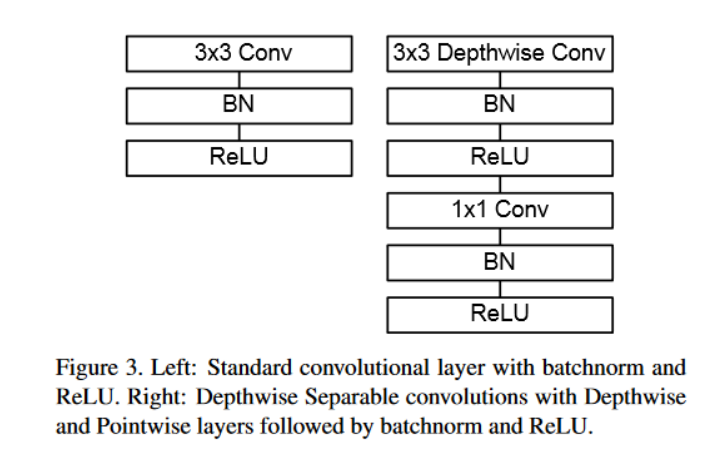

Справа на изображении представлен 1 блок MobileNet v1. В нем свертка 3x3 заменена на Depthwise convolution. Напоминание о ней ниже:

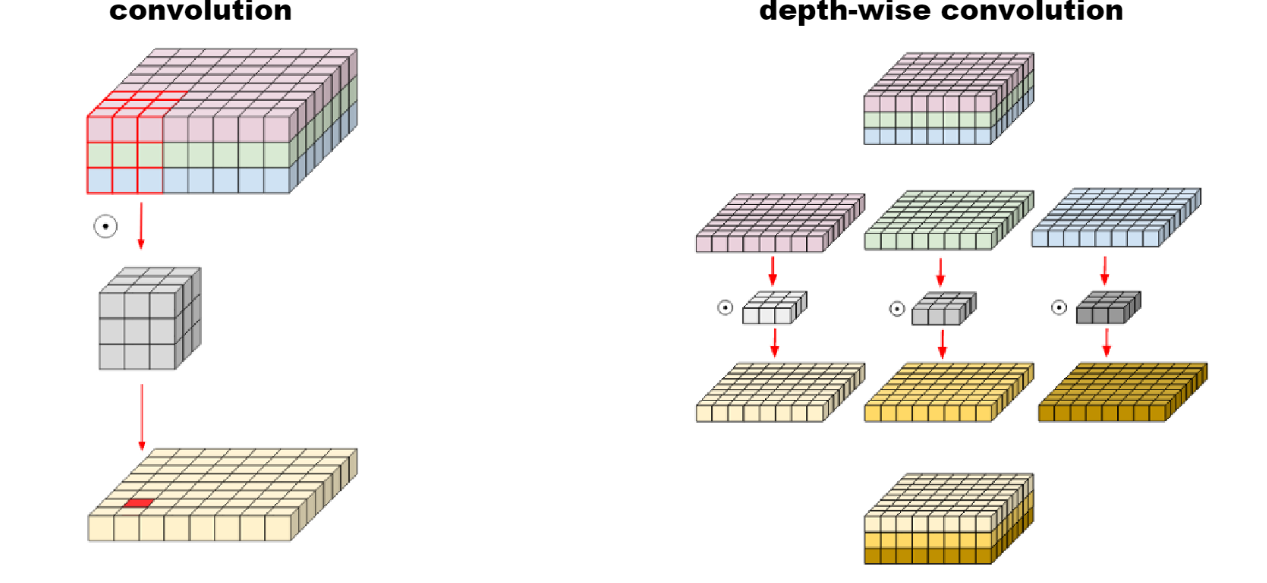

Данная свертка экономит число параметров, а так же увеличивает скорость обучения сети. Почему? Расчеты ниже:

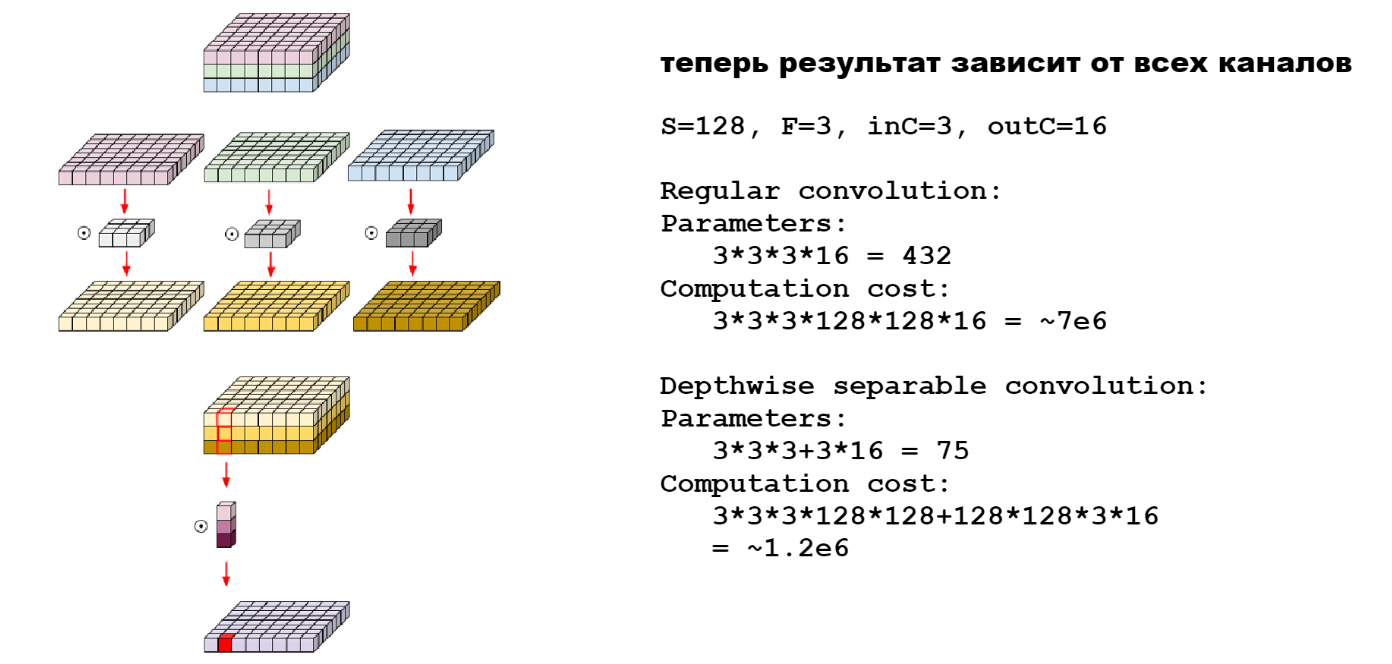

Видим, что на данном примере Depthwise свертка использует почти в 6 раз меньше параметров, чем обычная 3х3. Вычислительная сложность в 6 раз меньше. А так как мобильные сети используются даже в смартфонах, быстро обучаются, не требуют больших вычислительных мощностей, то это как раз то, что нужно.

Интересный факт: в данной сети нет MaxPool, вместо этого в свёртках stride=2

## Архитектура MobileNet

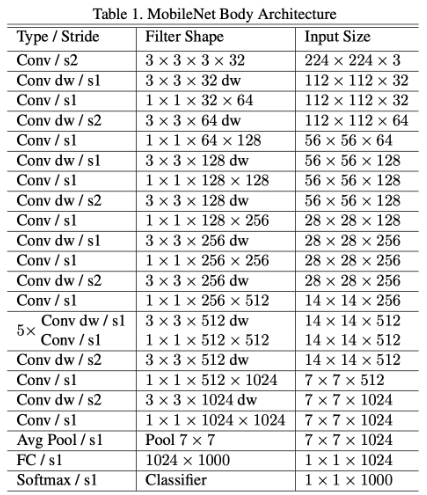

# Реализация MobileNet

In [57]:
#!g1.1
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 1.3 MB/s            
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [58]:
#!g1.1
import matplotlib.pyplot as plt
plt.style.use('classic')

from IPython import display

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from tqdm import tqdm
from time import time
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formats = ['svg', 'pdf']
from time import time
from matplotlib import pyplot as plt

In [59]:
#!g1.1
%pip install torch-summary

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [60]:
#!g1.1
import torch.nn as nn
from torchsummary import summary

class MobileNetV1(nn.Module):
    def __init__(self):
        super(MobileNetV1, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
                )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # dw
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),

                # pw
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            conv_bn(3, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

# Создадим dataloader, датасет - SVHN

https://github.com/mmp-practicum-team/mmp_practicum_spring_2022/blob/main/Seminars/Seminar%2004/cifar10_tutorial.ipynb

In [61]:
#!g1.1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                     download=True, transform=transform)


testset = torchvision.datasets.SVHN(root='./data', split='test',
                                    download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64,
                         shuffle=True, num_workers=2)

testloader = DataLoader(testset, batch_size=64,
                        shuffle=False, num_workers=2)



Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [62]:
#!g1.1
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [63]:
#!g1.1
iter(trainloader).next()[0].size()

torch.Size([64, 3, 32, 32])

In [64]:
#!g1.1
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Примеры данных

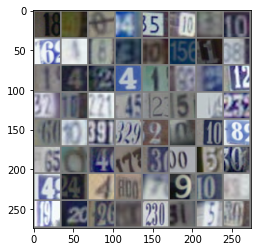

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dataiter
  warnings.warn(message)


In [34]:
#!g1.1
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

Задание метода оптимизации и функции потерь:

In [65]:
#!g1.1
num_epoch = 12
batch_size = 8
lr = 1e-4
weight_decay = 1e-4
step_size = 50
gamma = 0.5

In [36]:
#!g1.1
model = MobileNetV1()

In [165]:
#!g1.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Функция для оценивания качества:

In [166]:
#!g1.1
def evaluate_net(net, testloader, use_cuda=True):
    net = net.eval()
    
    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            if use_cuda:
                images = images.cuda()
            
            outputs = net(images).cpu()
            _, predicted = torch.max(outputs.data, dim=1)
            
            total += labels.size(0)
            correct += float((predicted == labels).sum())
            loss += float(criterion(outputs, labels))
    
    mean_loss = loss / total
    accuracy = correct / total
    
    return mean_loss, accuracy

In [167]:
#!g1.1
def class_evaluation(net, testloader, use_cuda=True):
    net = net.eval()
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            if use_cuda:
                images = images.cuda()
            
            outputs = net(images).cpu()
            
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i]
                class_total[label] += 1

    class_correct = [
        float(x)
        for x in class_correct
    ]

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [168]:
#!g1.1
def plt_graphics(verbose_data):
    plt.clf()
    display.clear_output(wait=True)
    display.display(plt.gcf())

    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(15)

    plt.subplot(1, 2, 1)
    plt.plot(verbose_data['train_verbose_steps'],
             verbose_data['train_loss'], 'b', linewidth=2)
    plt.plot(verbose_data['test_verbose_steps'],
             verbose_data['test_loss'], 'r', linewidth=2)
    plt.legend(['train', 'test'], fontsize=14)

    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(verbose_data['test_verbose_steps'],
             verbose_data['test_accuracy'], 'r', linewidth=2)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('accuracy', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    plt.grid()
    plt.show()

In [169]:
#!g1.1
def optimize_net(n_epochs, net, optimizer, criterion,
                 trainloader, testloader,
                 use_cuda=True, verbose=True, batch_verbose_proportion=0.5, 
                 verbose_data=None):
    net = net.train()
    
    n_batches = len(trainloader)
    n_batches_for_verbose = int(n_batches * batch_verbose_proportion)    
    
    
    if verbose_data is None:
        verbose_data = {
            'train_verbose_steps': [],
            'train_loss': [],
            'test_verbose_steps': [],
            'test_loss': [],
            'test_accuracy': [],
        }
    
    # loop over the dataset multiple times
    for epoch in range(n_epochs):  
        running_loss = 0.0
        total_objects = 0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
        
            # move data to cuda if need
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += float(loss)
            total_objects += outputs.shape[0]
            
            
            # save info sometimes
            if i % n_batches_for_verbose == n_batches_for_verbose - 1:
                epoch_value = epoch + np.around(i / n_batches, 2)
                new_train_loss = running_loss / total_objects
                running_loss = 0
                total_objects = 0
                
                verbose_data['train_verbose_steps'].append(epoch_value)
                verbose_data['train_loss'].append(new_train_loss * 100)            
                
                if verbose:
                    plt_graphics(verbose_data)
                
        # save info about test 
        test_loss, test_accuracy = evaluate_net(net, testloader)
        verbose_data['test_verbose_steps'].append(epoch + 1)
        verbose_data['test_loss'].append(test_loss * 100)
        verbose_data['test_accuracy'].append(test_accuracy * 100)
            
        if verbose:
            plt_graphics(verbose_data)
            
    return verbose_data

In [170]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

cuda:0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

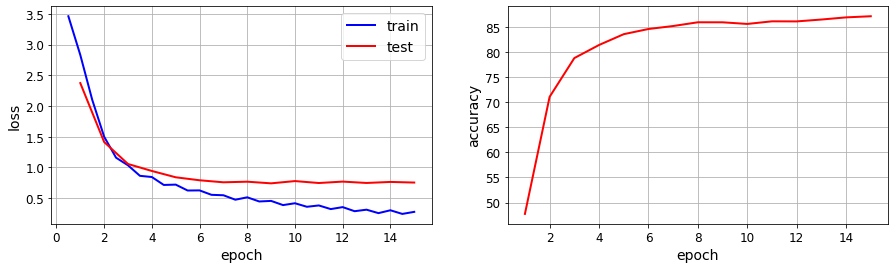

In [43]:
#!g1.1
linear_net_data = optimize_net(
    15, model, optimizer, criterion,
    trainloader, testloader,
    use_cuda=True, verbose=True
)

Время обучения - 6 мин

In [44]:
#!g1.1
max(linear_net_data['test_accuracy'])

87.18884449907806

In [45]:
#!g1.1
class_evaluation(model, testloader)

Accuracy of     0 : 77 %
Accuracy of     1 : 91 %
Accuracy of     2 : 92 %
Accuracy of     3 : 81 %
Accuracy of     4 : 90 %
Accuracy of     5 : 77 %
Accuracy of     6 : 84 %
Accuracy of     7 : 79 %
Accuracy of     8 : 75 %
Accuracy of     9 : 84 %


In [46]:
#!g1.1
def show(imgs, classes):
    imgs_to_show = []
    for res in imgs:
        image_to_show = res.transpose(0, 1).transpose(1, 2).numpy()
        image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        image_to_show = np.clip(image_to_show, 0, 1)
        imgs_to_show.append(image_to_show)

    
    
    for i in range(5):
        fig = plt.figure(figsize=(30, 30))
        for j in range(6):
          ax = fig.add_subplot(5, 6, j + 1)
          ax.set_title("MobileNet predict: " + str(classes[i*5 + j]), fontsize=30)
          ax.imshow(imgs_to_show[i*5 + j])
          ax.axis('off')  
        plt.tight_layout()
        plt.show()

In [47]:
#!g1.1
with torch.no_grad():
    model = model.eval()
    img, label = next(iter(testloader))
    img = img.to(device)
    label = label.to(device)

    pred = model(img)

    img = img.to('cpu')
    pred = pred.to('cpu')

    pred_class = []
    for p in pred:
        pred_class.append(np.argmax(p).numpy())

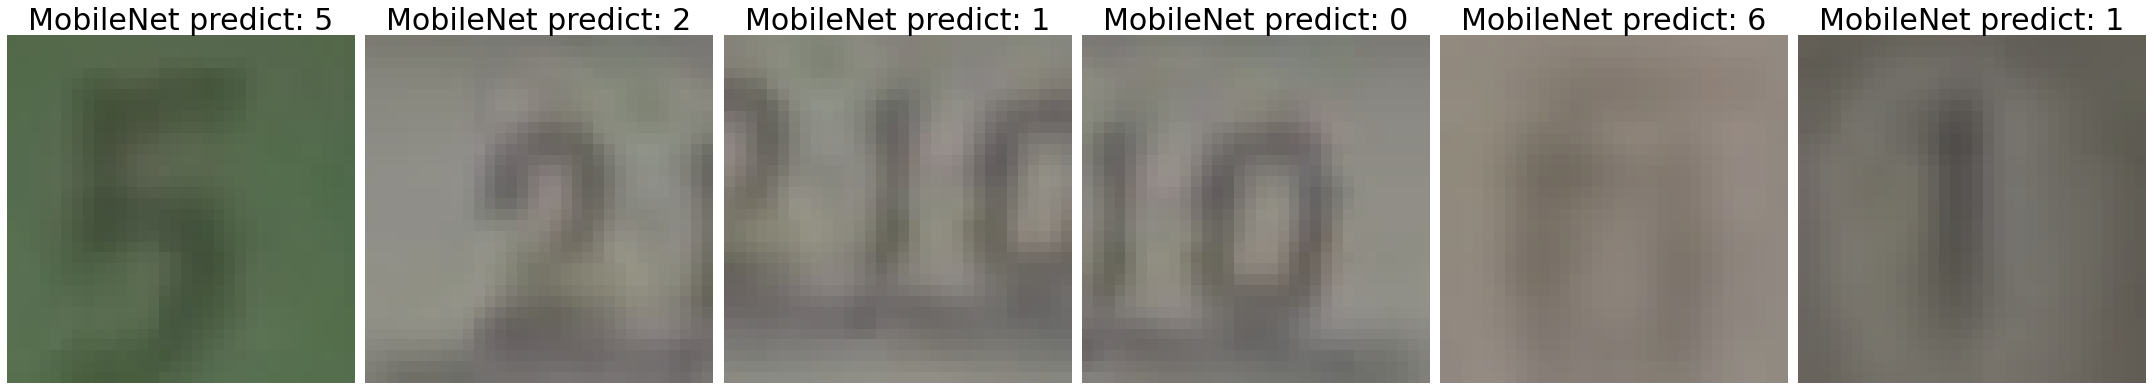

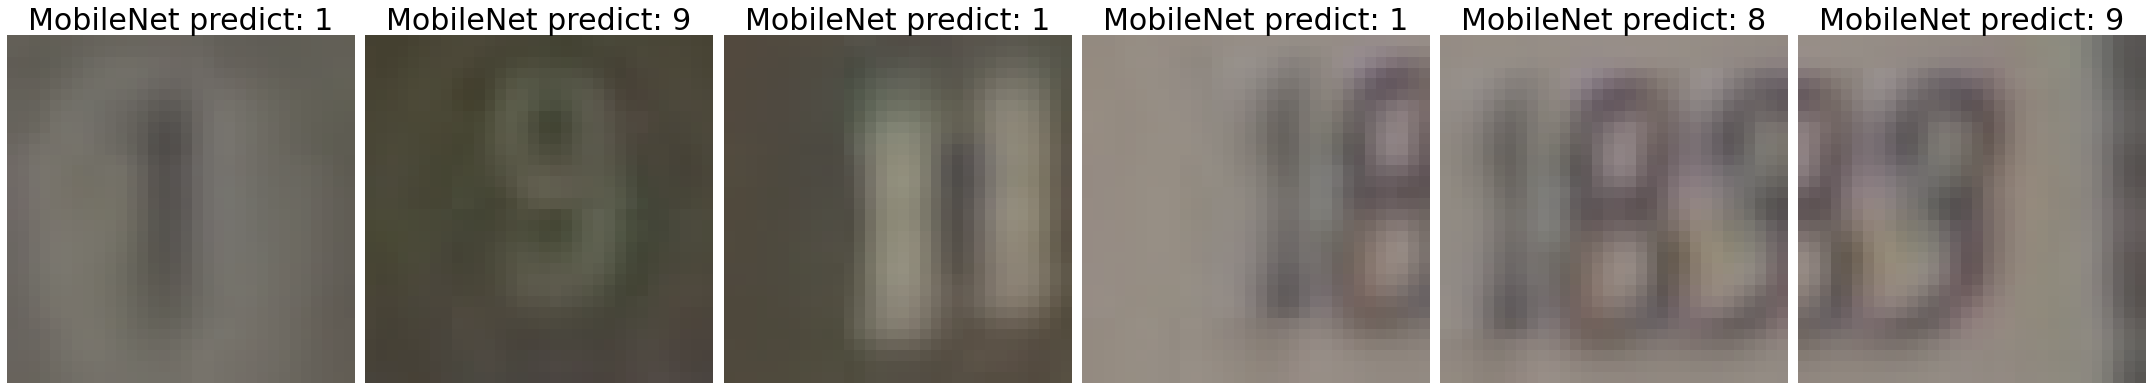

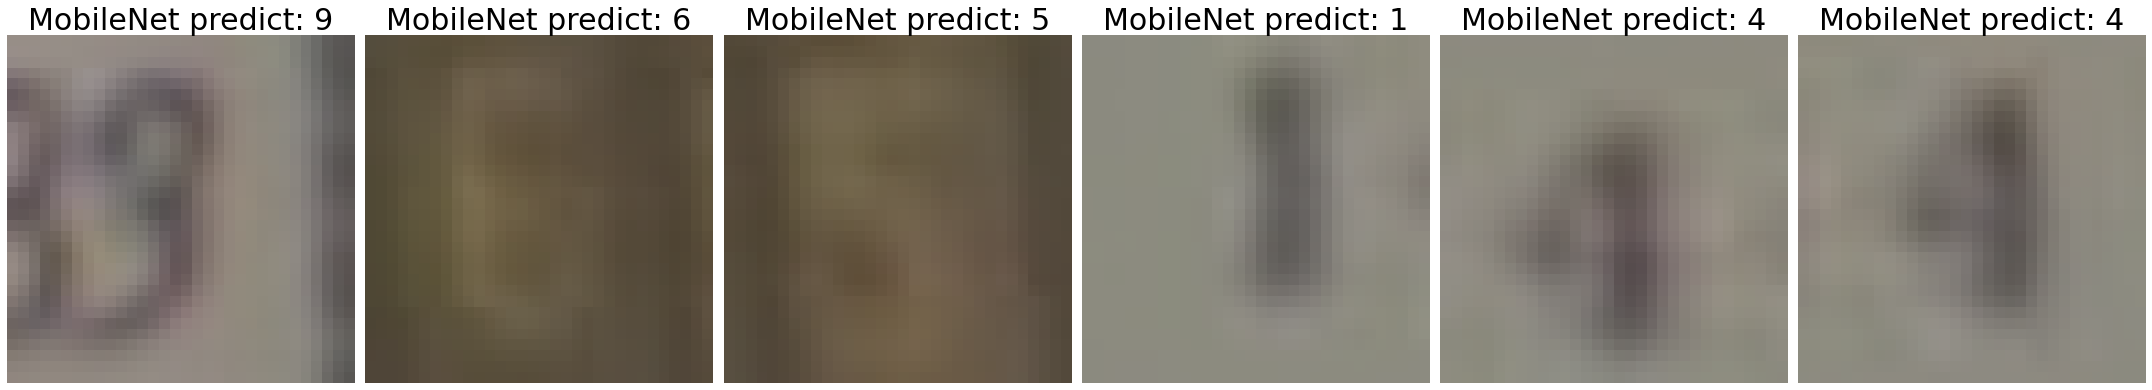

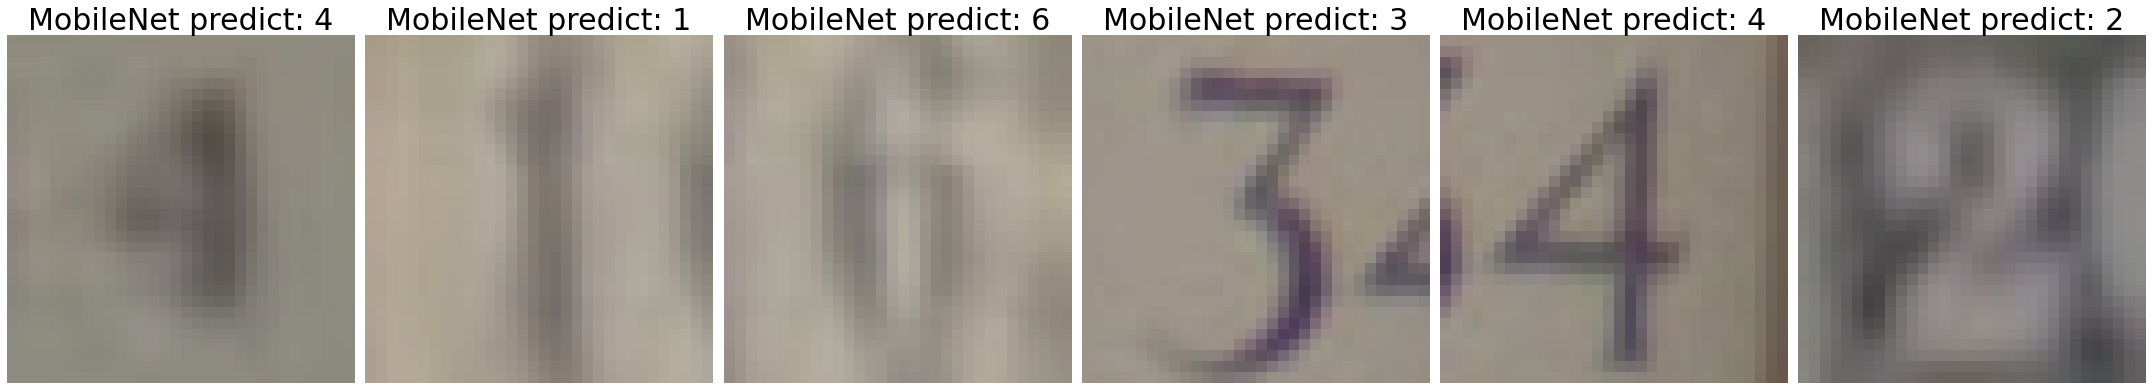

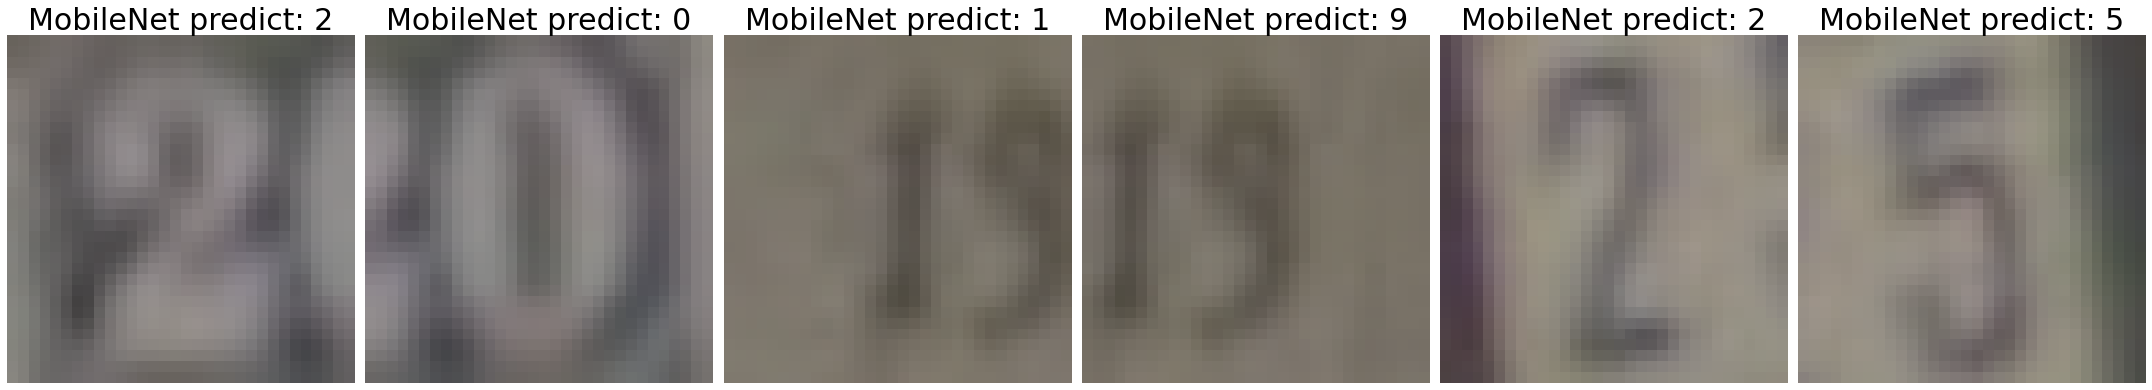

In [48]:
#!g1.1
show(img, pred_class)

Можно увидеть, как сеть перепутала 3 и 9 на последнем изображении во второй строке

Мы получили стартовое accuracy при базовых параметрах - 87.19%.

Лучший результат на данном датасе у MobileNet - около 91.53%

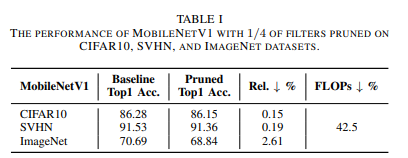

# Аугментация

В качестве аугментации изображения используем повороты на рандомные 10 градусов и рандомное повышение контраста изображения

In [171]:
#!g1.1
from torchvision.transforms.transforms import RandomRotation
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                     download=True, transform=transform_train)


testset = torchvision.datasets.SVHN(root='./data', split='test',
                                    download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=64,
                         shuffle=True, num_workers=2)

testloader = DataLoader(testset, batch_size=64,
                        shuffle=False, num_workers=2)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


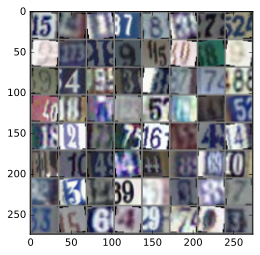

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dataiter
  warnings.warn(message)


In [172]:
#!g1.1
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

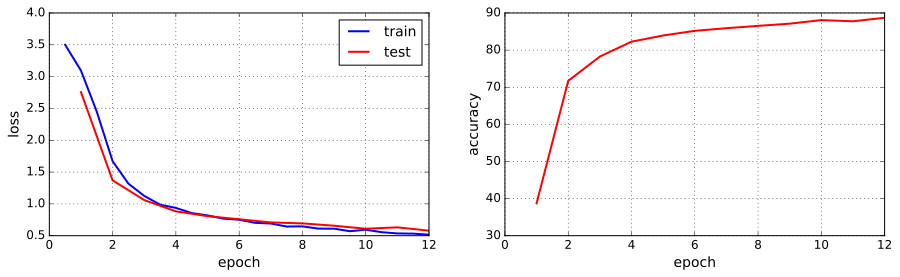

In [173]:
#!g1.1
model = MobileNetV1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
t1 = time()
linear_net_data = optimize_net(
    12, model, optimizer, criterion,
    trainloader, testloader,
    use_cuda=True, verbose=True
)
t2 = time()

In [174]:
#!g1.1
max(linear_net_data['test_accuracy'])

88.7062077443147

Аугментация повысила качество нашего классификатора

# Batch / LR

Немного изменим вывод статистики

In [99]:
#!g1.1
def optimize_net(n_epochs, net, optimizer, criterion,
                 trainloader, testloader,
                 use_cuda=True, verbose=True, batch_verbose_proportion=0.5, 
                 verbose_data=None):
    net = net.train()
    
    n_batches = len(trainloader)
    n_batches_for_verbose = int(n_batches * batch_verbose_proportion)    
    
    
    if verbose_data is None:
        verbose_data = {
            'train_verbose_steps': [],
            'train_loss': [],
            'test_verbose_steps': [],
            'test_loss': [],
            'test_accuracy': [],
        }
    
    # loop over the dataset multiple times
    for epoch in tqdm(range(n_epochs)):  
        running_loss = 0.0
        total_objects = 0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
        
            # move data to cuda if need
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += float(loss)
            total_objects += outputs.shape[0]            
                
        # save info about test 
        test_loss, test_accuracy = evaluate_net(net, testloader)
        print(f"  epoch: {epoch}, loss: {test_loss:.3f}, accuracy: {test_accuracy:.3f}")
        verbose_data['test_verbose_steps'].append(epoch + 1)
        verbose_data['test_loss'].append(test_loss)
        verbose_data['test_accuracy'].append(test_accuracy * 100)
            
    return verbose_data

### Сравним точность при следующих размерах батчей: 16, 24, 32, 64


In [73]:
#!g1.1
batch_list = [16, 24, 32, 64]
test_info = []

for batch in batch_list:
    model = MobileNetV1()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    trainloader = DataLoader(trainset, batch_size=batch,
                         shuffle=True, num_workers=2)

    testloader = DataLoader(testset, batch_size=batch,
                            shuffle=False, num_workers=2)
    print(f"batch_size: {batch}")
    test_data = optimize_net(
        12, model, optimizer, criterion,
        trainloader, testloader,
        use_cuda=True, verbose=True
    )
    test_info.append(test_data)

  0%|          | 0/12 [00:00<?, ?it/s]

batch_size: 16


  8%|▊         | 1/12 [01:23<15:23, 83.98s/it]

  epoch: 0, loss: 0.055, accuracy: 0.725


 17%|█▋        | 2/12 [02:41<13:40, 82.04s/it]

  epoch: 1, loss: 0.037, accuracy: 0.824


 25%|██▌       | 3/12 [04:01<12:12, 81.38s/it]

  epoch: 2, loss: 0.031, accuracy: 0.849


 33%|███▎      | 4/12 [05:18<10:42, 80.25s/it]

  epoch: 3, loss: 0.029, accuracy: 0.860


 42%|████▏     | 5/12 [06:37<09:18, 79.78s/it]

  epoch: 4, loss: 0.028, accuracy: 0.869


 50%|█████     | 6/12 [07:56<07:56, 79.42s/it]

  epoch: 5, loss: 0.025, accuracy: 0.882


 58%|█████▊    | 7/12 [09:14<06:35, 79.16s/it]

  epoch: 6, loss: 0.025, accuracy: 0.885


 67%|██████▋   | 8/12 [10:32<05:14, 78.65s/it]

  epoch: 7, loss: 0.025, accuracy: 0.882


 75%|███████▌  | 9/12 [11:51<03:56, 78.83s/it]

  epoch: 8, loss: 0.025, accuracy: 0.883


 83%|████████▎ | 10/12 [13:09<02:37, 78.52s/it]

  epoch: 9, loss: 0.025, accuracy: 0.890


 92%|█████████▏| 11/12 [14:28<01:18, 78.69s/it]

  epoch: 10, loss: 0.026, accuracy: 0.888


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.023, accuracy: 0.897
batch_size: 24


  8%|▊         | 1/12 [00:59<10:49, 59.02s/it]

  epoch: 0, loss: 0.040, accuracy: 0.697


 17%|█▋        | 2/12 [01:51<09:31, 57.12s/it]

  epoch: 1, loss: 0.026, accuracy: 0.808


 25%|██▌       | 3/12 [02:44<08:21, 55.69s/it]

  epoch: 2, loss: 0.022, accuracy: 0.842


 33%|███▎      | 4/12 [03:36<07:17, 54.65s/it]

  epoch: 3, loss: 0.020, accuracy: 0.854


 42%|████▏     | 5/12 [04:29<06:19, 54.15s/it]

  epoch: 4, loss: 0.017, accuracy: 0.876


 50%|█████     | 6/12 [05:23<05:25, 54.25s/it]

  epoch: 5, loss: 0.017, accuracy: 0.875


 58%|█████▊    | 7/12 [06:17<04:30, 54.15s/it]

  epoch: 6, loss: 0.017, accuracy: 0.875


 67%|██████▋   | 8/12 [07:10<03:35, 53.88s/it]

  epoch: 7, loss: 0.016, accuracy: 0.881


 75%|███████▌  | 9/12 [08:03<02:40, 53.54s/it]

  epoch: 8, loss: 0.017, accuracy: 0.883


 83%|████████▎ | 10/12 [08:57<01:46, 53.48s/it]

  epoch: 9, loss: 0.018, accuracy: 0.885


 92%|█████████▏| 11/12 [09:49<00:53, 53.11s/it]

  epoch: 10, loss: 0.018, accuracy: 0.882


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.019, accuracy: 0.876
batch_size: 32


  8%|▊         | 1/12 [00:50<09:10, 50.03s/it]

  epoch: 0, loss: 0.036, accuracy: 0.624


 17%|█▋        | 2/12 [01:34<08:04, 48.44s/it]

  epoch: 1, loss: 0.020, accuracy: 0.804


 25%|██▌       | 3/12 [02:21<07:10, 47.83s/it]

  epoch: 2, loss: 0.016, accuracy: 0.845


 33%|███▎      | 4/12 [03:07<06:18, 47.35s/it]

  epoch: 3, loss: 0.016, accuracy: 0.853


 42%|████▏     | 5/12 [03:52<05:26, 46.60s/it]

  epoch: 4, loss: 0.014, accuracy: 0.863


 50%|█████     | 6/12 [04:37<04:37, 46.33s/it]

  epoch: 5, loss: 0.014, accuracy: 0.865


 58%|█████▊    | 7/12 [05:22<03:49, 45.92s/it]

  epoch: 6, loss: 0.013, accuracy: 0.876


 67%|██████▋   | 8/12 [06:09<03:04, 46.06s/it]

  epoch: 7, loss: 0.014, accuracy: 0.872


 75%|███████▌  | 9/12 [06:55<02:17, 45.96s/it]

  epoch: 8, loss: 0.013, accuracy: 0.877


 83%|████████▎ | 10/12 [07:40<01:31, 45.91s/it]

  epoch: 9, loss: 0.014, accuracy: 0.876


 92%|█████████▏| 11/12 [08:25<00:45, 45.52s/it]

  epoch: 10, loss: 0.013, accuracy: 0.885


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.013, accuracy: 0.886
batch_size: 64


  8%|▊         | 1/12 [00:25<04:43, 25.77s/it]

  epoch: 0, loss: 0.026, accuracy: 0.430


 17%|█▋        | 2/12 [00:51<04:16, 25.67s/it]

  epoch: 1, loss: 0.016, accuracy: 0.685


 25%|██▌       | 3/12 [01:15<03:47, 25.27s/it]

  epoch: 2, loss: 0.012, accuracy: 0.768


 33%|███▎      | 4/12 [01:39<03:19, 24.93s/it]

  epoch: 3, loss: 0.010, accuracy: 0.807


 42%|████▏     | 5/12 [02:03<02:52, 24.66s/it]

  epoch: 4, loss: 0.009, accuracy: 0.821


 50%|█████     | 6/12 [02:27<02:26, 24.41s/it]

  epoch: 5, loss: 0.008, accuracy: 0.834


 58%|█████▊    | 7/12 [02:50<02:00, 24.04s/it]

  epoch: 6, loss: 0.008, accuracy: 0.838


 67%|██████▋   | 8/12 [03:13<01:35, 23.80s/it]

  epoch: 7, loss: 0.008, accuracy: 0.845


 75%|███████▌  | 9/12 [03:38<01:12, 24.03s/it]

  epoch: 8, loss: 0.009, accuracy: 0.841


 83%|████████▎ | 10/12 [04:01<00:47, 23.73s/it]

  epoch: 9, loss: 0.008, accuracy: 0.846


 92%|█████████▏| 11/12 [04:25<00:23, 23.69s/it]

  epoch: 10, loss: 0.009, accuracy: 0.850


100%|██████████| 12/12 [04:49<00:00, 24.10s/it]

  epoch: 11, loss: 0.009, accuracy: 0.849


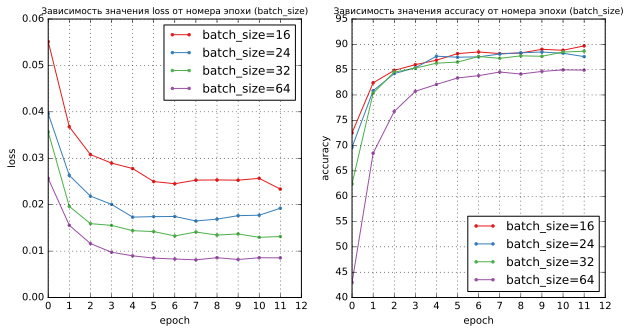

In [101]:
#!g1.1
sns.set_palette("Set1")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Зависимость значения loss от номера эпохи (batch_size)", fontsize=9)

real_info = []
for info in test_info:
    real_loss = []
    for loss in info['test_loss']:
        real_loss.append(loss / 100)
    real_info.append(real_loss)

for i in range(len(batch_list)):
    plt.plot(np.arange(12), real_info[i], marker='.', label="batch_size="+str(batch_list[i]))
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend()

ax = fig.add_subplot(122)
plt.xlabel('epoch')

plt.ylabel('accuracy')
plt.title("Зависимость значения accuracy от номера эпохи (batch_size)", fontsize=9)
for i in range(len(batch_list)):
    plt.plot(np.arange(12), test_info[i]['test_accuracy'], marker='.', label="batch_size="+str(batch_list[i]))
plt.legend(loc='lower right')
plt.yticks(np.arange(40, 96, 5))
plt.xticks(np.arange(0, 13, 1))
plt.grid(True)

plt.show()


## Вывод:
Получаем примерно одинаковые результаты при размере батча в 16, 24 и 32 изображения. Далее будем использовать batch_size = 16

Если посмотреть на левый график, то можно заметить, что у лучшего по точности размера батча наибольшее значение функции потерь, скорее всего это происходит из-за того, что мы рассмотрели очень мало эпох и при большем их числе ситуация поменяется на противоположную

### Сравним точность при следующих значениях learning_rate: 0.0001, 0.001, 0.01

In [103]:
#!g1.1
lr_list = [1e-4, 1e-3, 1e-2]
test_lr_info = []

for lr in lr_list:
    model = MobileNetV1()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    trainloader = DataLoader(trainset, batch_size=16,
                         shuffle=True, num_workers=2)

    testloader = DataLoader(testset, batch_size=16,
                            shuffle=False, num_workers=2)
    print(f"learning_rate: {lr}")
    test_data = optimize_net(
        12, model, optimizer, criterion,
        trainloader, testloader,
        use_cuda=True, verbose=True
    )
    test_lr_info.append(test_data)

  0%|          | 0/12 [00:00<?, ?it/s]

learning_rate: 0.0001


  8%|▊         | 1/12 [01:25<15:43, 85.81s/it]

  epoch: 0, loss: 0.138, accuracy: 0.219


 17%|█▋        | 2/12 [02:45<13:58, 83.89s/it]

  epoch: 1, loss: 0.098, accuracy: 0.468


 25%|██▌       | 3/12 [04:06<12:26, 82.99s/it]

  epoch: 2, loss: 0.067, accuracy: 0.649


 33%|███▎      | 4/12 [05:25<10:55, 81.99s/it]

  epoch: 3, loss: 0.052, accuracy: 0.737


 42%|████▏     | 5/12 [06:45<09:30, 81.44s/it]

  epoch: 4, loss: 0.046, accuracy: 0.767


 50%|█████     | 6/12 [08:05<08:05, 80.87s/it]

  epoch: 5, loss: 0.041, accuracy: 0.798


 58%|█████▊    | 7/12 [09:24<06:42, 80.46s/it]

  epoch: 6, loss: 0.039, accuracy: 0.807


 67%|██████▋   | 8/12 [10:45<05:21, 80.37s/it]

  epoch: 7, loss: 0.037, accuracy: 0.815


 75%|███████▌  | 9/12 [12:04<04:00, 80.21s/it]

  epoch: 8, loss: 0.036, accuracy: 0.823


 83%|████████▎ | 10/12 [13:24<02:40, 80.16s/it]

  epoch: 9, loss: 0.036, accuracy: 0.822


 92%|█████████▏| 11/12 [14:45<01:20, 80.12s/it]

  epoch: 10, loss: 0.037, accuracy: 0.826


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.037, accuracy: 0.821
learning_rate: 0.001


  8%|▊         | 1/12 [01:25<15:45, 85.98s/it]

  epoch: 0, loss: 0.067, accuracy: 0.672


 17%|█▋        | 2/12 [02:45<14:01, 84.13s/it]

  epoch: 1, loss: 0.041, accuracy: 0.794


 25%|██▌       | 3/12 [04:05<12:26, 82.93s/it]

  epoch: 2, loss: 0.033, accuracy: 0.836


 33%|███▎      | 4/12 [05:25<10:56, 82.05s/it]

  epoch: 3, loss: 0.030, accuracy: 0.854


 42%|████▏     | 5/12 [06:49<09:36, 82.38s/it]

  epoch: 4, loss: 0.027, accuracy: 0.868


 50%|█████     | 6/12 [08:08<08:09, 81.63s/it]

  epoch: 5, loss: 0.026, accuracy: 0.874


 58%|█████▊    | 7/12 [09:28<06:45, 81.09s/it]

  epoch: 6, loss: 0.027, accuracy: 0.872


 67%|██████▋   | 8/12 [10:50<05:24, 81.20s/it]

  epoch: 7, loss: 0.025, accuracy: 0.883


 75%|███████▌  | 9/12 [12:10<04:02, 80.93s/it]

  epoch: 8, loss: 0.026, accuracy: 0.881


 83%|████████▎ | 10/12 [13:31<02:41, 80.97s/it]

  epoch: 9, loss: 0.027, accuracy: 0.878


 92%|█████████▏| 11/12 [14:52<01:21, 81.08s/it]

  epoch: 10, loss: 0.026, accuracy: 0.887


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.026, accuracy: 0.888
learning_rate: 0.01


  8%|▊         | 1/12 [01:27<16:06, 87.87s/it]

  epoch: 0, loss: 0.054, accuracy: 0.760


 17%|█▋        | 2/12 [02:49<14:18, 85.86s/it]

  epoch: 1, loss: 0.035, accuracy: 0.834


 25%|██▌       | 3/12 [04:08<12:35, 83.95s/it]

  epoch: 2, loss: 0.032, accuracy: 0.851


 33%|███▎      | 4/12 [05:28<11:01, 82.74s/it]

  epoch: 3, loss: 0.028, accuracy: 0.867


 42%|████▏     | 5/12 [06:48<09:33, 81.94s/it]

  epoch: 4, loss: 0.024, accuracy: 0.894


 50%|█████     | 6/12 [08:08<08:08, 81.38s/it]

  epoch: 5, loss: 0.023, accuracy: 0.886


 58%|█████▊    | 7/12 [09:29<06:46, 81.22s/it]

  epoch: 6, loss: 0.023, accuracy: 0.892


 67%|██████▋   | 8/12 [10:49<05:23, 80.95s/it]

  epoch: 7, loss: 0.022, accuracy: 0.899


 75%|███████▌  | 9/12 [12:08<04:01, 80.35s/it]

  epoch: 8, loss: 0.020, accuracy: 0.905


 83%|████████▎ | 10/12 [13:26<02:38, 79.49s/it]

  epoch: 9, loss: 0.023, accuracy: 0.893


 92%|█████████▏| 11/12 [14:43<01:18, 78.85s/it]

  epoch: 10, loss: 0.021, accuracy: 0.901


100%|██████████| 12/12 [16:00<00:00, 80.02s/it]

  epoch: 11, loss: 0.020, accuracy: 0.910


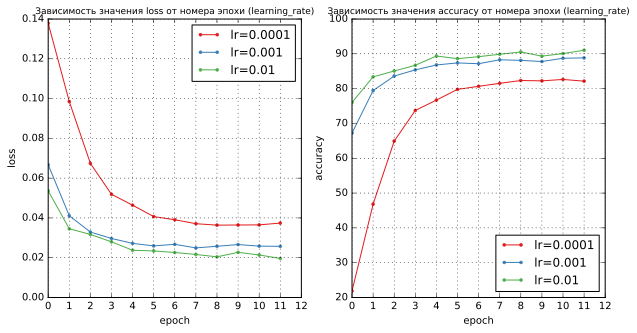

In [107]:
#!g1.1
sns.set_palette("Set1")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Зависимость значения loss от номера эпохи (learning_rate)", fontsize=9)
for i in range(len(lr_list)):
    plt.plot(np.arange(12), test_lr_info[i]['test_loss'], marker='.', label=f"lr={lr_list[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend()

ax = fig.add_subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Зависимость значения accuracy от номера эпохи (learning_rate)", fontsize=9)
for i in range(len(lr_list)):
    plt.plot(np.arange(12), test_lr_info[i]['test_accuracy'], marker='.', label=f"lr={lr_list[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend(loc='lower right')
plt.show()

### Вывод:
По графику можно заметить, что при learning_rate=0.0001 мы нашли какой-то не самый наименьший локальный минимум, нам нужно больше эпох, чтобы сойти до глобального, хотя есть большая вероятность, что с таким маленьким шагом этого не произойдет.

Аналогично с шагом learning_rate=0.001, нужно большее число эпох.
Поэтому далее используем learning_rate=0.01

# Оптимизатор + gradient clipping

### Рассмотрим 2 оптимизатора: SGD и Adam

In [110]:
#!g1.1
opt_names = ['SGD', 'Adam']
test_opt_info = []

for opt in opt_names:
    model = MobileNetV1()
    criterion = nn.CrossEntropyLoss()
    if opt == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    trainloader = DataLoader(trainset, batch_size=16,
                         shuffle=True, num_workers=2)

    testloader = DataLoader(testset, batch_size=16,
                            shuffle=False, num_workers=2)
    print(f"optimizer: {opt}")
    test_data = optimize_net(
        12, model, optimizer, criterion,
        trainloader, testloader,
        use_cuda=True, verbose=True
    )
    test_opt_info.append(test_data)

  0%|          | 0/12 [00:00<?, ?it/s]

optimizer: SGD


  8%|▊         | 1/12 [01:24<15:24, 84.09s/it]

  epoch: 0, loss: 0.053, accuracy: 0.746


 17%|█▋        | 2/12 [02:41<13:40, 82.08s/it]

  epoch: 1, loss: 0.031, accuracy: 0.853


 25%|██▌       | 3/12 [04:00<12:09, 81.03s/it]

  epoch: 2, loss: 0.027, accuracy: 0.875


 33%|███▎      | 4/12 [05:17<10:39, 79.95s/it]

  epoch: 3, loss: 0.025, accuracy: 0.882


 42%|████▏     | 5/12 [06:35<09:14, 79.24s/it]

  epoch: 4, loss: 0.023, accuracy: 0.893


 50%|█████     | 6/12 [07:53<07:53, 78.85s/it]

  epoch: 5, loss: 0.022, accuracy: 0.898


 58%|█████▊    | 7/12 [09:11<06:33, 78.77s/it]

  epoch: 6, loss: 0.020, accuracy: 0.907


 67%|██████▋   | 8/12 [10:31<05:16, 79.01s/it]

  epoch: 7, loss: 0.021, accuracy: 0.902


 75%|███████▌  | 9/12 [11:49<03:56, 78.93s/it]

  epoch: 8, loss: 0.022, accuracy: 0.896


 83%|████████▎ | 10/12 [13:09<02:38, 79.18s/it]

  epoch: 9, loss: 0.021, accuracy: 0.901


 92%|█████████▏| 11/12 [14:30<01:19, 79.68s/it]

  epoch: 10, loss: 0.022, accuracy: 0.899


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.020, accuracy: 0.911
optimizer: Adam


  8%|▊         | 1/12 [01:45<19:20, 105.52s/it]

  epoch: 0, loss: 0.058, accuracy: 0.715


 17%|█▋        | 2/12 [03:26<17:20, 104.07s/it]

  epoch: 1, loss: 2229367411375993245132652544.000, accuracy: 0.159


 25%|██▌       | 3/12 [05:04<15:21, 102.38s/it]

  epoch: 2, loss: nan, accuracy: 0.067


 33%|███▎      | 4/12 [06:41<13:25, 100.72s/it]

  epoch: 3, loss: nan, accuracy: 0.067


 42%|████▏     | 5/12 [08:18<11:37, 99.71s/it] 

  epoch: 4, loss: nan, accuracy: 0.067


 42%|████▏     | 5/12 [08:44<12:14, 104.90s/it]


KeyboardInterrupt: 

### Ой... gradient explosion
Сразу на второй эпохе замечаем проблему взрывающихся градиентов. Для нее характерно следующее:
1. Значение функции потерь принимает значение NaN
2. Модель плохо обучается на данных, что отражается в высоком значении функции потерь.
3. Модель нестабильна, что отражается в значительных скачках значения функции потерь.

Поэтому добавим gradient clipping, заодно запустим SGD вместе с gradient clipping.

Сохраним нормальный результат у оптимизатора SGD, когда мы не обрезаем градиенты

In [112]:
#!g1.1
simple_sgd = test_opt_info[0]

Добавляем обрезку градиентов

In [176]:
#!g1.1
def optimize_net(n_epochs, net, optimizer, criterion,
                 trainloader, testloader,
                 use_cuda=True, verbose=True, batch_verbose_proportion=0.5, 
                 verbose_data=None, l1=None, gc=False):
    net = net.train()
    
    n_batches = len(trainloader)
    n_batches_for_verbose = int(n_batches * batch_verbose_proportion)    
    
    
    if verbose_data is None:
        verbose_data = {
            'train_verbose_steps': [],
            'train_loss': [],
            'test_verbose_steps': [],
            'test_loss': [],
            'test_accuracy': [],
        }
    
    # loop over the dataset multiple times
    for epoch in tqdm(range(n_epochs)):  
        running_loss = 0.0
        total_objects = 0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
        
            # move data to cuda if need
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            if l1 is not None:
                L1_reg = torch.tensor(0., requires_grad=True)
                for name, param in net.named_parameters():
                    if 'weight' in name:
                        L1_reg = L1_reg + torch.norm(param, 1)

                loss = loss + l1 * L1_reg

            loss.backward()
            if gc:
                nn.utils.clip_grad_norm_(net.parameters(), max_norm=10, norm_type=2)
            optimizer.step()

            # print statistics
            running_loss += float(loss)
            total_objects += outputs.shape[0]            
                
        # save info about test 
        test_loss, test_accuracy = evaluate_net(net, testloader)
        print(f"  epoch: {epoch}, loss: {test_loss:.3f}, accuracy: {test_accuracy:.3f}")
        verbose_data['test_verbose_steps'].append(epoch + 1)
        verbose_data['test_loss'].append(test_loss)
        verbose_data['test_accuracy'].append(test_accuracy * 100)
            
    return verbose_data

In [ ]:
#!g1.1
model = MobileNetV1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4, eps=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
trainloader = DataLoader(trainset, batch_size=16,
                     shuffle=True, num_workers=2)

testloader = DataLoader(testset, batch_size=16,
                        shuffle=False, num_workers=2)
print(f"optimizer: {opt}")
test_data = optimize_net(
    12, model, optimizer, criterion,
    trainloader, testloader,
    use_cuda=True, verbose=True
)
adam_gr_clip.append(test_data)

In [133]:
#!g1.1
model = MobileNetV1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4, eps=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
trainloader = DataLoader(trainset, batch_size=16,
                     shuffle=True, num_workers=2)

testloader = DataLoader(testset, batch_size=16,
                        shuffle=False, num_workers=2)
print(f"optimizer: Adam, lr = 0.01")
test1_data = optimize_net(
    12, model, optimizer, criterion,
    trainloader, testloader,
    use_cuda=True, verbose=True
)
adam_gr_clip = test_data

  0%|          | 0/12 [00:00<?, ?it/s]

optimizer: Adam, lr = 0.01


  8%|▊         | 1/12 [01:55<21:10, 115.48s/it]

  epoch: 0, loss: 0.139, accuracy: 0.196


 17%|█▋        | 2/12 [03:44<18:55, 113.54s/it]

  epoch: 1, loss: 0.139, accuracy: 0.196


 25%|██▌       | 3/12 [05:33<16:50, 112.24s/it]

  epoch: 2, loss: 0.139, accuracy: 0.196


 33%|███▎      | 4/12 [07:22<14:50, 111.25s/it]

  epoch: 3, loss: 0.139, accuracy: 0.196


 33%|███▎      | 4/12 [08:54<17:48, 133.58s/it]


KeyboardInterrupt: 

## Ой... x2
Уже по первым эпохам можем сделать вывод, что значение learning_rate 0.01 не подходит для оптимизатора с алгоритмом Adam, этот шаг слишком большой, в минимум мы не сойдемся, далее ждать не будем, прервем ядро.

Это логично, ведь когда мы подбирали значение learning_rate, то фиксировали оптимизатор SGD. Поэтому будет честно протестировать модель с оптимизатором Adam на значениях learning_rate поменьше, например 0.001 и 0.0001. Что сделаем нижe:

learning_rate: 0.001

In [127]:
#!g1.1
model = MobileNetV1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
trainloader = DataLoader(trainset, batch_size=16,
                     shuffle=True, num_workers=2)

testloader = DataLoader(testset, batch_size=16,
                        shuffle=False, num_workers=2)
print(f"optimizer: {opt}")
test_data = optimize_net(
    12, model, optimizer, criterion,
    trainloader, testloader,
    use_cuda=True, verbose=True
)
adam_gr_clip.append(test_data)

  0%|          | 0/12 [00:00<?, ?it/s]

optimizer: Adam


  8%|▊         | 1/12 [01:59<21:51, 119.21s/it]

  epoch: 0, loss: 0.043, accuracy: 0.817


 17%|█▋        | 2/12 [03:51<19:31, 117.13s/it]

  epoch: 1, loss: 0.033, accuracy: 0.856


 25%|██▌       | 3/12 [05:44<17:23, 115.98s/it]

  epoch: 2, loss: 0.030, accuracy: 0.870


 33%|███▎      | 4/12 [07:37<15:20, 115.06s/it]

  epoch: 3, loss: 0.027, accuracy: 0.878


 42%|████▏     | 5/12 [09:31<13:22, 114.64s/it]

  epoch: 4, loss: 0.026, accuracy: 0.881


 50%|█████     | 6/12 [11:24<11:25, 114.18s/it]

  epoch: 5, loss: 0.024, accuracy: 0.895


 58%|█████▊    | 7/12 [13:17<09:28, 113.76s/it]

  epoch: 6, loss: 0.024, accuracy: 0.891


 67%|██████▋   | 8/12 [15:07<07:30, 112.67s/it]

  epoch: 7, loss: 0.021, accuracy: 0.907


 75%|███████▌  | 9/12 [16:54<05:32, 110.95s/it]

  epoch: 8, loss: 0.024, accuracy: 0.894


 83%|████████▎ | 10/12 [18:41<03:39, 109.74s/it]

  epoch: 9, loss: 0.022, accuracy: 0.902


 92%|█████████▏| 11/12 [20:28<01:49, 109.07s/it]

  epoch: 10, loss: 0.023, accuracy: 0.898


100%|██████████| 12/12 [22:16<00:00, 111.35s/it]

  epoch: 11, loss: 0.023, accuracy: 0.903


NameError: name 'adam_gr_clip' is not defined

In [129]:
#!g1.1
adam_gr_clip_2 = test_data

learning rate: 0.0001

In [134]:
#!g1.1
model = MobileNetV1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4, eps=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
trainloader = DataLoader(trainset, batch_size=16,
                     shuffle=True, num_workers=2)

testloader = DataLoader(testset, batch_size=16,
                        shuffle=False, num_workers=2)
print(f"optimizer: Adam, learning_rate: 0.0001")
test2_data = optimize_net(
    12, model, optimizer, criterion,
    trainloader, testloader,
    use_cuda=True, verbose=True
)
adam_gr_clip_3 = test2_data

  0%|          | 0/12 [00:00<?, ?it/s]

optimizer: Adam, learning_rate: 0.0001


  8%|▊         | 1/12 [01:55<21:14, 115.90s/it]

  epoch: 0, loss: 0.122, accuracy: 0.333


 17%|█▋        | 2/12 [03:46<19:04, 114.46s/it]

  epoch: 1, loss: 0.062, accuracy: 0.676


 25%|██▌       | 3/12 [05:37<17:00, 113.34s/it]

  epoch: 2, loss: 0.049, accuracy: 0.765


 33%|███▎      | 4/12 [07:29<15:02, 112.87s/it]

  epoch: 3, loss: 0.039, accuracy: 0.808


 42%|████▏     | 5/12 [09:21<13:09, 112.74s/it]

  epoch: 4, loss: 0.034, accuracy: 0.842


 50%|█████     | 6/12 [11:14<11:16, 112.79s/it]

  epoch: 5, loss: 0.031, accuracy: 0.859


 58%|█████▊    | 7/12 [13:07<09:23, 112.72s/it]

  epoch: 6, loss: 0.033, accuracy: 0.856


 67%|██████▋   | 8/12 [15:03<07:34, 113.72s/it]

  epoch: 7, loss: 0.033, accuracy: 0.857


 75%|███████▌  | 9/12 [16:58<05:42, 114.09s/it]

  epoch: 8, loss: 0.035, accuracy: 0.856


 83%|████████▎ | 10/12 [18:52<03:48, 114.08s/it]

  epoch: 9, loss: 0.036, accuracy: 0.857


 92%|█████████▏| 11/12 [20:47<01:54, 114.43s/it]

  epoch: 10, loss: 0.034, accuracy: 0.857


100%|██████████| 12/12 [22:41<00:00, 113.50s/it]

  epoch: 11, loss: 0.035, accuracy: 0.867


Теперь запустим SGD с обрезкой градиентов с оптимальным для него learning_rate = 0.01:

In [137]:
#!g1.1
model = MobileNetV1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
trainloader = DataLoader(trainset, batch_size=16,
                     shuffle=True, num_workers=2)

testloader = DataLoader(testset, batch_size=16,
                        shuffle=False, num_workers=2)
print(f"optimizer: SGD, learning_rate: 0.01, gradient clipping")
test3_data = optimize_net(
    12, model, optimizer, criterion,
    trainloader, testloader,
    use_cuda=True, verbose=True
)
sgd_gr_clip = test3_data

  0%|          | 0/12 [00:00<?, ?it/s]

optimizer: SGD, learning_rate: 0.01, gradient clipping


  8%|▊         | 1/12 [01:37<17:49, 97.20s/it]

  epoch: 0, loss: 0.038, accuracy: 0.810


 17%|█▋        | 2/12 [03:08<15:54, 95.47s/it]

  epoch: 1, loss: 0.035, accuracy: 0.838


 25%|██▌       | 3/12 [04:39<14:06, 94.10s/it]

  epoch: 2, loss: 0.026, accuracy: 0.880


 33%|███▎      | 4/12 [06:09<12:23, 92.91s/it]

  epoch: 3, loss: 0.026, accuracy: 0.880


 42%|████▏     | 5/12 [07:40<10:46, 92.38s/it]

  epoch: 4, loss: 0.022, accuracy: 0.896


 50%|█████     | 6/12 [09:11<09:11, 91.86s/it]

  epoch: 5, loss: 0.022, accuracy: 0.897


 58%|█████▊    | 7/12 [10:42<07:38, 91.66s/it]

  epoch: 6, loss: 0.022, accuracy: 0.898


 67%|██████▋   | 8/12 [12:13<06:05, 91.48s/it]

  epoch: 7, loss: 0.021, accuracy: 0.907


 75%|███████▌  | 9/12 [13:46<04:35, 91.99s/it]

  epoch: 8, loss: 0.019, accuracy: 0.911


 83%|████████▎ | 10/12 [15:22<03:06, 93.06s/it]

  epoch: 9, loss: 0.020, accuracy: 0.908


 92%|█████████▏| 11/12 [16:56<01:33, 93.25s/it]

  epoch: 10, loss: 0.019, accuracy: 0.912


100%|██████████| 12/12 [18:28<00:00, 92.40s/it]

  epoch: 11, loss: 0.020, accuracy: 0.911


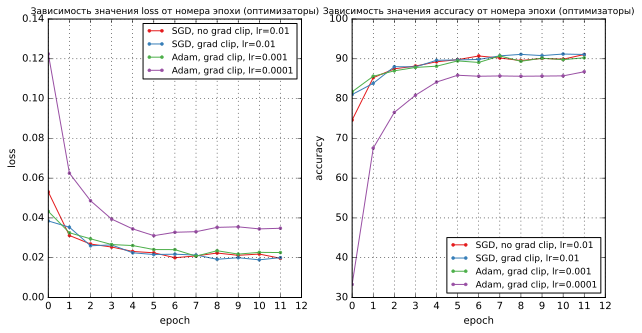

In [141]:
#!g1.1
sns.set_palette("Set1")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Зависимость значения loss от номера эпохи (оптимизаторы)", fontsize=9)

plt.plot(np.arange(12), simple_sgd['test_loss'], marker='.', label=f"SGD, no grad clip, lr=0.01")
plt.plot(np.arange(12), sgd_gr_clip['test_loss'], marker='.', label=f"SGD, grad clip, lr=0.01")
plt.plot(np.arange(12), adam_gr_clip_2['test_loss'], marker='.', label=f"Adam, grad clip, lr=0.001")
plt.plot(np.arange(12), adam_gr_clip_3['test_loss'], marker='.', label=f"Adam, grad clip, lr=0.0001")

plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend(fontsize = 9)

ax = fig.add_subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Зависимость значения accuracy от номера эпохи (оптимизаторы)", fontsize=9)
plt.plot(np.arange(12), simple_sgd['test_accuracy'], marker='.', label=f"SGD, no grad clip, lr=0.01")
plt.plot(np.arange(12), sgd_gr_clip['test_accuracy'], marker='.', label=f"SGD, grad clip, lr=0.01")
plt.plot(np.arange(12), adam_gr_clip_2['test_accuracy'], marker='.', label=f"Adam, grad clip, lr=0.001")
plt.plot(np.arange(12), adam_gr_clip_3['test_accuracy'], marker='.', label=f"Adam, grad clip, lr=0.0001")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend(loc='lower right', fontsize = 9)
plt.show()

Видим, что 3 алгоритма: SGD без обрезки градиентов с lr=0.01, SGD c обрезкой градиентов с lr=0.01 и Adam с обрезкой градиентов и lr=0.001 - показывают схожие отличные результаты по точности, второй алгоритм чуть-чуть получше, далее будем использовать его. 

Для Adam с обрезкой градиентов и lr=0.0001 необходимо большее число эпох, чтобы достичь наибольшей точности, видим по графику, что он еще не вышел на плато. Это логично, так как шаг для градиентного спуска меньше, дольше будем сходиться к минимуму.

# Программатор

### Возьмем для сравнения следующие программаторы: StepLR, ExponentialLR

# StepLR

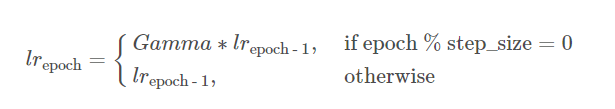
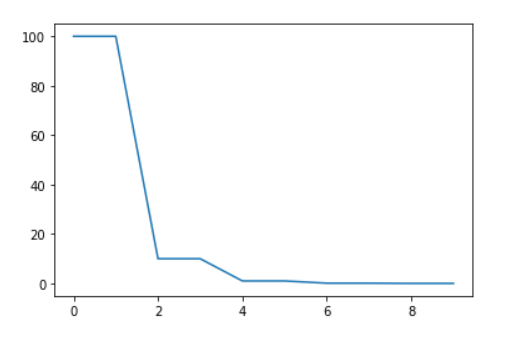

# ExponentialLR

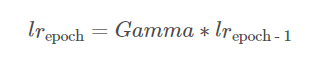
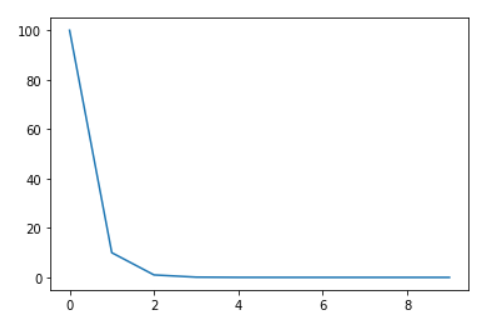

# MultiplicativeLR

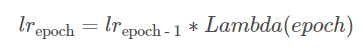
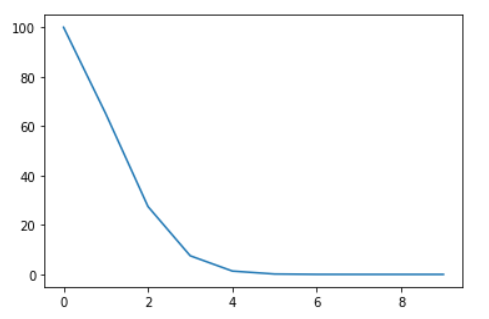

# LambdaLR

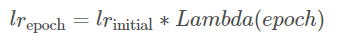
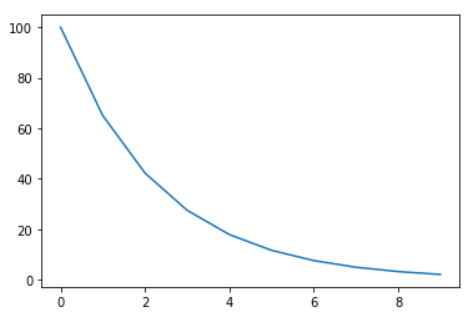

# CosineAnnealingLR

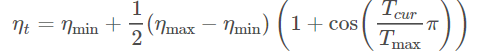
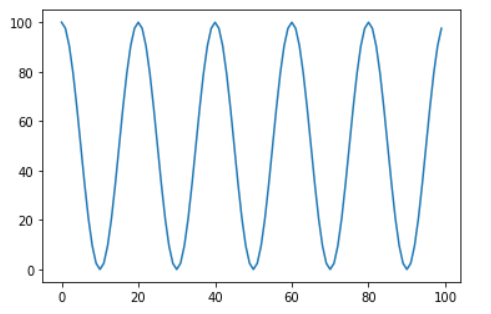

Для следующих двух экспериментов увеличим размер батча, для более быстрых вычислений, зато здесь переберем больше вариантов программаторов

In [147]:
#!g1.1
pr_names = ['StepLR', 'ExponentialLR', 'MultiplicativeLR', 'LambdaLR', 'CosineAnnealingLR']
test_pr_info = []

for pr in pr_names:
    model = MobileNetV1()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    if pr == 'StepLR':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif pr == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif pr == 'MultiplicativeLR':
        lmbda = lambda epoch: 0.65 ** epoch
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
    elif pr == 'LambdaLR':
        lambda1 = lambda epoch: 0.65 ** epoch
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    else:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    trainloader = DataLoader(trainset, batch_size=64,
                         shuffle=True, num_workers=2)

    testloader = DataLoader(testset, batch_size=64,
                            shuffle=False, num_workers=2)
    print(f"scheduler: {pr}")
    test4_data = optimize_net(
        12, model, optimizer, criterion,
        trainloader, testloader,
        use_cuda=True, verbose=True
    )
    test_pr_info.append(test4_data)

  0%|          | 0/12 [00:00<?, ?it/s]

scheduler: StepLR


  8%|▊         | 1/12 [00:29<05:22, 29.30s/it]

  epoch: 0, loss: 0.011, accuracy: 0.771


 17%|█▋        | 2/12 [00:55<04:44, 28.49s/it]

  epoch: 1, loss: 0.008, accuracy: 0.845


 25%|██▌       | 3/12 [01:23<04:14, 28.23s/it]

  epoch: 2, loss: 0.007, accuracy: 0.860


 33%|███▎      | 4/12 [01:51<03:45, 28.19s/it]

  epoch: 3, loss: 0.006, accuracy: 0.880


 42%|████▏     | 5/12 [02:19<03:16, 28.08s/it]

  epoch: 4, loss: 0.006, accuracy: 0.896


 50%|█████     | 6/12 [02:46<02:47, 27.84s/it]

  epoch: 5, loss: 0.006, accuracy: 0.891


 58%|█████▊    | 7/12 [03:15<02:20, 28.01s/it]

  epoch: 6, loss: 0.005, accuracy: 0.901


 67%|██████▋   | 8/12 [03:42<01:50, 27.68s/it]

  epoch: 7, loss: 0.005, accuracy: 0.900


 75%|███████▌  | 9/12 [04:09<01:23, 27.69s/it]

  epoch: 8, loss: 0.005, accuracy: 0.904


 83%|████████▎ | 10/12 [04:36<00:54, 27.32s/it]

  epoch: 9, loss: 0.005, accuracy: 0.902


 92%|█████████▏| 11/12 [05:03<00:27, 27.18s/it]

  epoch: 10, loss: 0.006, accuracy: 0.897


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.005, accuracy: 0.907
scheduler: ExponentialLR


  8%|▊         | 1/12 [00:29<05:23, 29.44s/it]

  epoch: 0, loss: 0.010, accuracy: 0.808


 17%|█▋        | 2/12 [00:58<04:52, 29.29s/it]

  epoch: 1, loss: 0.008, accuracy: 0.843


 25%|██▌       | 3/12 [01:25<04:17, 28.58s/it]

  epoch: 2, loss: 0.007, accuracy: 0.868


 33%|███▎      | 4/12 [01:52<03:46, 28.30s/it]

  epoch: 3, loss: 0.006, accuracy: 0.889


 42%|████▏     | 5/12 [02:20<03:16, 28.13s/it]

  epoch: 4, loss: 0.006, accuracy: 0.890


 50%|█████     | 6/12 [02:47<02:46, 27.75s/it]

  epoch: 5, loss: 0.006, accuracy: 0.893


 58%|█████▊    | 7/12 [03:14<02:17, 27.57s/it]

  epoch: 6, loss: 0.005, accuracy: 0.902


 67%|██████▋   | 8/12 [03:43<01:52, 28.01s/it]

  epoch: 7, loss: 0.005, accuracy: 0.904


 75%|███████▌  | 9/12 [04:10<01:22, 27.64s/it]

  epoch: 8, loss: 0.005, accuracy: 0.906


 83%|████████▎ | 10/12 [04:37<00:54, 27.37s/it]

  epoch: 9, loss: 0.005, accuracy: 0.907


 92%|█████████▏| 11/12 [05:04<00:27, 27.23s/it]

  epoch: 10, loss: 0.006, accuracy: 0.908


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.006, accuracy: 0.901
scheduler: MultiplicativeLR


  8%|▊         | 1/12 [00:28<05:15, 28.71s/it]

  epoch: 0, loss: 0.010, accuracy: 0.800


 17%|█▋        | 2/12 [00:56<04:44, 28.47s/it]

  epoch: 1, loss: 0.008, accuracy: 0.848


 25%|██▌       | 3/12 [01:23<04:12, 28.01s/it]

  epoch: 2, loss: 0.007, accuracy: 0.868


 33%|███▎      | 4/12 [01:51<03:43, 27.92s/it]

  epoch: 3, loss: 0.006, accuracy: 0.879


 42%|████▏     | 5/12 [02:18<03:13, 27.70s/it]

  epoch: 4, loss: 0.006, accuracy: 0.887


 50%|█████     | 6/12 [02:45<02:44, 27.40s/it]

  epoch: 5, loss: 0.006, accuracy: 0.896


 58%|█████▊    | 7/12 [03:13<02:18, 27.76s/it]

  epoch: 6, loss: 0.006, accuracy: 0.889


 67%|██████▋   | 8/12 [03:40<01:50, 27.58s/it]

  epoch: 7, loss: 0.005, accuracy: 0.898


 75%|███████▌  | 9/12 [04:07<01:22, 27.38s/it]

  epoch: 8, loss: 0.005, accuracy: 0.908


 83%|████████▎ | 10/12 [04:35<00:54, 27.40s/it]

  epoch: 9, loss: 0.005, accuracy: 0.904


 92%|█████████▏| 11/12 [05:02<00:27, 27.46s/it]

  epoch: 10, loss: 0.006, accuracy: 0.903


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.005, accuracy: 0.910
scheduler: LambdaLR


  8%|▊         | 1/12 [00:28<05:17, 28.83s/it]

  epoch: 0, loss: 0.032, accuracy: 0.633


 17%|█▋        | 2/12 [00:55<04:43, 28.33s/it]

  epoch: 1, loss: 0.009, accuracy: 0.832


 25%|██▌       | 3/12 [01:23<04:13, 28.21s/it]

  epoch: 2, loss: 0.007, accuracy: 0.871


 33%|███▎      | 4/12 [01:51<03:43, 28.00s/it]

  epoch: 3, loss: 0.007, accuracy: 0.875


 42%|████▏     | 5/12 [02:18<03:13, 27.70s/it]

  epoch: 4, loss: 0.006, accuracy: 0.882


 50%|█████     | 6/12 [02:45<02:45, 27.60s/it]

  epoch: 5, loss: 0.006, accuracy: 0.893


 58%|█████▊    | 7/12 [03:12<02:16, 27.33s/it]

  epoch: 6, loss: 0.006, accuracy: 0.898


 67%|██████▋   | 8/12 [03:39<01:48, 27.22s/it]

  epoch: 7, loss: 0.006, accuracy: 0.890


 75%|███████▌  | 9/12 [04:07<01:22, 27.49s/it]

  epoch: 8, loss: 0.006, accuracy: 0.896


 83%|████████▎ | 10/12 [04:35<00:54, 27.48s/it]

  epoch: 9, loss: 0.005, accuracy: 0.903


 92%|█████████▏| 11/12 [05:02<00:27, 27.58s/it]

  epoch: 10, loss: 0.006, accuracy: 0.900


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.006, accuracy: 0.895
scheduler: CosineAnnealingLR


  8%|▊         | 1/12 [00:29<05:25, 29.57s/it]

  epoch: 0, loss: 0.011, accuracy: 0.792


 17%|█▋        | 2/12 [00:57<04:51, 29.20s/it]

  epoch: 1, loss: 0.009, accuracy: 0.825


 25%|██▌       | 3/12 [01:25<04:18, 28.74s/it]

  epoch: 2, loss: 0.007, accuracy: 0.856


 33%|███▎      | 4/12 [01:53<03:48, 28.53s/it]

  epoch: 3, loss: 0.006, accuracy: 0.890


 42%|████▏     | 5/12 [02:22<03:19, 28.51s/it]

  epoch: 4, loss: 0.006, accuracy: 0.893


 50%|█████     | 6/12 [02:49<02:48, 28.08s/it]

  epoch: 5, loss: 0.006, accuracy: 0.891


 58%|█████▊    | 7/12 [03:16<02:18, 27.73s/it]

  epoch: 6, loss: 0.005, accuracy: 0.903


 67%|██████▋   | 8/12 [03:43<01:50, 27.60s/it]

  epoch: 7, loss: 0.006, accuracy: 0.897


 75%|███████▌  | 9/12 [04:11<01:23, 27.85s/it]

  epoch: 8, loss: 0.005, accuracy: 0.899


 83%|████████▎ | 10/12 [04:40<00:56, 28.19s/it]

  epoch: 9, loss: 0.006, accuracy: 0.900


 92%|█████████▏| 11/12 [05:08<00:28, 28.09s/it]

  epoch: 10, loss: 0.005, accuracy: 0.905


100%|██████████| 12/12 [05:36<00:00, 28.02s/it]

  epoch: 11, loss: 0.005, accuracy: 0.905


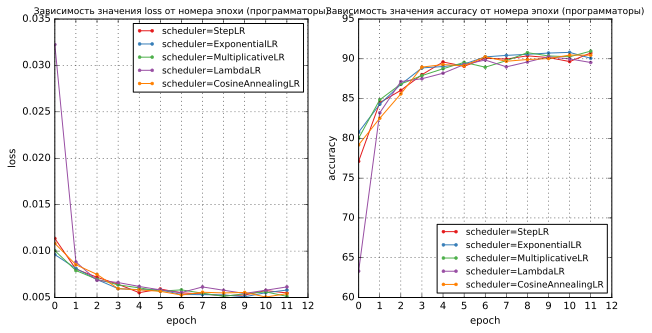

In [150]:
#!g1.1
sns.set_palette("Set1")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Зависимость значения loss от номера эпохи (программаторы)", fontsize=9)
for i in range(len(pr_names)):
    plt.plot(np.arange(12), test_pr_info[i]['test_loss'], marker='.', label=f"scheduler={pr_names[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend(fontsize=9)

ax = fig.add_subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Зависимость значения accuracy от номера эпохи (программаторы)", fontsize=9)
for i in range(len(pr_names)):
    plt.plot(np.arange(12), test_pr_info[i]['test_accuracy'], marker='.', label=f"scheduler={pr_names[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend(loc='lower right', fontsize=9)
plt.show()

## Вывод:
Получили практически одинаковые кривые для всех программаторов. Это можно объяснить тем, что они ведут себя по-разному только на первых эпохах, а уже к восьмой эпохе все очень сильно замедляют шаг для того, чтобы сойтись в минимуме и не проскачить его из-за большого размера learning rate.

Поэтому в нашей задаче нет разницы, какой программатор выбирать.

# Регуляризация

### L2 регуляризация
За L2 регуляризацию отвечает значение weight_decay в нашем оптимизаторе

Рассмотрим следующие варианты данного гиперпараметра: 1e-2, 1e-3, 1e-4, 1e-5, 1e-6

In [151]:
#!g1.1
wd_list = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
test_wd_info = []

for wd in wd_list:
    model = MobileNetV1()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=wd)
    lmbda = lambda epoch: 0.65 ** epoch
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    trainloader = DataLoader(trainset, batch_size=64,
                         shuffle=True, num_workers=2)

    testloader = DataLoader(testset, batch_size=64,
                            shuffle=False, num_workers=2)
    print(f"weight_decay: {wd}")
    test5_data = optimize_net(
        12, model, optimizer, criterion,
        trainloader, testloader,
        use_cuda=True, verbose=True
    )
    test_wd_info.append(test5_data)

  0%|          | 0/12 [00:00<?, ?it/s]

weight_decay: 0.01


  8%|▊         | 1/12 [00:31<05:42, 31.12s/it]

  epoch: 0, loss: 0.011, accuracy: 0.801


 17%|█▋        | 2/12 [00:58<04:59, 29.93s/it]

  epoch: 1, loss: 0.012, accuracy: 0.790


 25%|██▌       | 3/12 [01:26<04:25, 29.49s/it]

  epoch: 2, loss: 0.010, accuracy: 0.819


 33%|███▎      | 4/12 [01:54<03:52, 29.05s/it]

  epoch: 3, loss: 0.012, accuracy: 0.772


 42%|████▏     | 5/12 [02:21<03:19, 28.48s/it]

  epoch: 4, loss: 0.010, accuracy: 0.803


 50%|█████     | 6/12 [02:49<02:48, 28.10s/it]

  epoch: 5, loss: 0.012, accuracy: 0.781


 58%|█████▊    | 7/12 [03:16<02:19, 27.93s/it]

  epoch: 6, loss: 0.013, accuracy: 0.779


 67%|██████▋   | 8/12 [03:43<01:50, 27.60s/it]

  epoch: 7, loss: 0.014, accuracy: 0.764


 75%|███████▌  | 9/12 [04:11<01:23, 27.72s/it]

  epoch: 8, loss: 0.012, accuracy: 0.785


 83%|████████▎ | 10/12 [04:39<00:55, 27.80s/it]

  epoch: 9, loss: 0.012, accuracy: 0.782


 92%|█████████▏| 11/12 [05:06<00:27, 27.63s/it]

  epoch: 10, loss: 0.014, accuracy: 0.765


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.012, accuracy: 0.782
weight_decay: 0.001


  8%|▊         | 1/12 [00:29<05:25, 29.56s/it]

  epoch: 0, loss: 0.010, accuracy: 0.800


 17%|█▋        | 2/12 [00:57<04:50, 29.06s/it]

  epoch: 1, loss: 0.008, accuracy: 0.853


 25%|██▌       | 3/12 [01:24<04:16, 28.48s/it]

  epoch: 2, loss: 0.007, accuracy: 0.862


 33%|███▎      | 4/12 [01:52<03:45, 28.25s/it]

  epoch: 3, loss: 0.007, accuracy: 0.875


 42%|████▏     | 5/12 [02:19<03:15, 27.95s/it]

  epoch: 4, loss: 0.006, accuracy: 0.877


 50%|█████     | 6/12 [02:48<02:49, 28.17s/it]

  epoch: 5, loss: 0.006, accuracy: 0.879


 58%|█████▊    | 7/12 [03:15<02:20, 28.01s/it]

  epoch: 6, loss: 0.005, accuracy: 0.898


 67%|██████▋   | 8/12 [03:44<01:52, 28.22s/it]

  epoch: 7, loss: 0.006, accuracy: 0.891


 75%|███████▌  | 9/12 [04:12<01:24, 28.22s/it]

  epoch: 8, loss: 0.005, accuracy: 0.903


 83%|████████▎ | 10/12 [04:39<00:55, 27.86s/it]

  epoch: 9, loss: 0.006, accuracy: 0.897


 92%|█████████▏| 11/12 [05:07<00:27, 27.67s/it]

  epoch: 10, loss: 0.006, accuracy: 0.897


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.005, accuracy: 0.909
weight_decay: 0.0001


  8%|▊         | 1/12 [00:28<05:14, 28.60s/it]

  epoch: 0, loss: 0.010, accuracy: 0.794


 17%|█▋        | 2/12 [00:56<04:43, 28.30s/it]

  epoch: 1, loss: 0.008, accuracy: 0.857


 25%|██▌       | 3/12 [01:23<04:12, 28.10s/it]

  epoch: 2, loss: 0.007, accuracy: 0.868


 33%|███▎      | 4/12 [01:51<03:44, 28.06s/it]

  epoch: 3, loss: 0.006, accuracy: 0.882


 42%|████▏     | 5/12 [02:19<03:15, 27.87s/it]

  epoch: 4, loss: 0.006, accuracy: 0.882


 50%|█████     | 6/12 [02:46<02:45, 27.66s/it]

  epoch: 5, loss: 0.006, accuracy: 0.881


 58%|█████▊    | 7/12 [03:14<02:18, 27.65s/it]

  epoch: 6, loss: 0.006, accuracy: 0.894


 67%|██████▋   | 8/12 [03:42<01:51, 27.76s/it]

  epoch: 7, loss: 0.005, accuracy: 0.903


 75%|███████▌  | 9/12 [04:10<01:23, 27.96s/it]

  epoch: 8, loss: 0.005, accuracy: 0.904


 83%|████████▎ | 10/12 [04:39<00:56, 28.17s/it]

  epoch: 9, loss: 0.005, accuracy: 0.907


 92%|█████████▏| 11/12 [05:07<00:28, 28.18s/it]

  epoch: 10, loss: 0.005, accuracy: 0.906


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.005, accuracy: 0.904
weight_decay: 1e-05


  8%|▊         | 1/12 [00:29<05:22, 29.34s/it]

  epoch: 0, loss: 0.010, accuracy: 0.803


 17%|█▋        | 2/12 [00:56<04:46, 28.66s/it]

  epoch: 1, loss: 0.008, accuracy: 0.852


 25%|██▌       | 3/12 [01:24<04:17, 28.58s/it]

  epoch: 2, loss: 0.007, accuracy: 0.868


 33%|███▎      | 4/12 [01:52<03:46, 28.28s/it]

  epoch: 3, loss: 0.006, accuracy: 0.884


 42%|████▏     | 5/12 [02:19<03:15, 28.00s/it]

  epoch: 4, loss: 0.006, accuracy: 0.880


 50%|█████     | 6/12 [02:47<02:47, 27.99s/it]

  epoch: 5, loss: 0.007, accuracy: 0.883


 58%|█████▊    | 7/12 [03:15<02:19, 27.82s/it]

  epoch: 6, loss: 0.006, accuracy: 0.888


 67%|██████▋   | 8/12 [03:42<01:51, 27.81s/it]

  epoch: 7, loss: 0.006, accuracy: 0.893


 75%|███████▌  | 9/12 [04:11<01:23, 27.92s/it]

  epoch: 8, loss: 0.005, accuracy: 0.901


 83%|████████▎ | 10/12 [04:38<00:55, 27.89s/it]

  epoch: 9, loss: 0.006, accuracy: 0.898


 92%|█████████▏| 11/12 [05:06<00:27, 27.86s/it]

  epoch: 10, loss: 0.006, accuracy: 0.897


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.005, accuracy: 0.904
weight_decay: 1e-06


  8%|▊         | 1/12 [00:29<05:24, 29.46s/it]

  epoch: 0, loss: 0.010, accuracy: 0.800


 17%|█▋        | 2/12 [00:58<04:52, 29.22s/it]

  epoch: 1, loss: 0.009, accuracy: 0.836


 25%|██▌       | 3/12 [01:25<04:19, 28.78s/it]

  epoch: 2, loss: 0.007, accuracy: 0.857


 33%|███▎      | 4/12 [01:54<03:49, 28.67s/it]

  epoch: 3, loss: 0.006, accuracy: 0.886


 42%|████▏     | 5/12 [02:22<03:19, 28.54s/it]

  epoch: 4, loss: 0.006, accuracy: 0.888


 50%|█████     | 6/12 [02:50<02:49, 28.31s/it]

  epoch: 5, loss: 0.006, accuracy: 0.889


 58%|█████▊    | 7/12 [03:17<02:20, 28.11s/it]

  epoch: 6, loss: 0.006, accuracy: 0.892


 67%|██████▋   | 8/12 [03:46<01:52, 28.24s/it]

  epoch: 7, loss: 0.006, accuracy: 0.895


 75%|███████▌  | 9/12 [04:13<01:23, 28.00s/it]

  epoch: 8, loss: 0.006, accuracy: 0.896


 83%|████████▎ | 10/12 [04:41<00:55, 27.72s/it]

  epoch: 9, loss: 0.006, accuracy: 0.900


 92%|█████████▏| 11/12 [05:08<00:27, 27.79s/it]

  epoch: 10, loss: 0.006, accuracy: 0.889


100%|██████████| 12/12 [05:37<00:00, 28.09s/it]

  epoch: 11, loss: 0.006, accuracy: 0.896


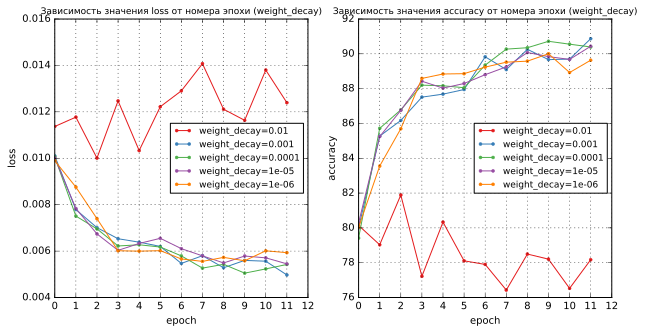

In [154]:
#!g1.1
sns.set_palette("Set1")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Зависимость значения loss от номера эпохи (weight_decay)", fontsize=9)
for i in range(len(wd_list)):
    plt.plot(np.arange(12), test_wd_info[i]['test_loss'], marker='.', label=f"weight_decay={wd_list[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend(fontsize=9, loc='center right')

ax = fig.add_subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Зависимость значения accuracy от номера эпохи (weight_decay)", fontsize=9)
for i in range(len(wd_list)):
    plt.plot(np.arange(12), test_wd_info[i]['test_accuracy'], marker='.', label=f"weight_decay={wd_list[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend(fontsize=9, loc='center right')
plt.show()

### Выводы:

При большом коэффициенте регуляризации (0.01) модель недообучается. Слишком маленькая регуляризация тоже не очень хорошо сказывается на качестве. 

Будем использовать далее weight_decay=0.001

## Добавим L1 регуляризацию

Рассмотрим следующие варианты коэффициента L1 регуляризации: 10e-3, 10e-4, 10e-5, 10e-6

In [158]:
#!g1.1
l1_list = [10e-3, 10e-4, 10e-5, 10e-6]
test_l1_info = []

for l1 in l1_list:
    model = MobileNetV1()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
    lmbda = lambda epoch: 0.65 ** epoch
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    trainloader = DataLoader(trainset, batch_size=64,
                             shuffle=True, num_workers=2)

    testloader = DataLoader(testset, batch_size=64,
                            shuffle=False, num_workers=2)
    print(f"l1 regularization coeff: {l1}")
    test7_data = optimize_net(
        12, model, optimizer, criterion,
        trainloader, testloader,
        use_cuda=True, verbose=True, l1=l1
    )
    test_l1_info.append(test7_data)

  0%|          | 0/12 [00:00<?, ?it/s]

l1 regularization coeff: 0.01


  8%|▊         | 1/12 [00:34<06:21, 34.67s/it]

  epoch: 0, loss: 0.035, accuracy: 0.196


 17%|█▋        | 2/12 [01:07<05:40, 34.03s/it]

  epoch: 1, loss: 0.035, accuracy: 0.196


 25%|██▌       | 3/12 [01:39<05:02, 33.57s/it]

  epoch: 2, loss: 0.035, accuracy: 0.196


 33%|███▎      | 4/12 [02:13<04:29, 33.63s/it]

  epoch: 3, loss: 0.035, accuracy: 0.196


 42%|████▏     | 5/12 [02:47<03:55, 33.62s/it]

  epoch: 4, loss: 0.035, accuracy: 0.196


 50%|█████     | 6/12 [03:20<03:20, 33.43s/it]

  epoch: 5, loss: 0.035, accuracy: 0.196


 58%|█████▊    | 7/12 [03:53<02:47, 33.51s/it]

  epoch: 6, loss: 0.035, accuracy: 0.196


 67%|██████▋   | 8/12 [04:25<02:12, 33.08s/it]

  epoch: 7, loss: 0.035, accuracy: 0.196


 75%|███████▌  | 9/12 [04:58<01:39, 33.05s/it]

  epoch: 8, loss: 0.035, accuracy: 0.196


 83%|████████▎ | 10/12 [05:31<01:05, 32.87s/it]

  epoch: 9, loss: 0.035, accuracy: 0.196


 92%|█████████▏| 11/12 [06:04<00:32, 32.96s/it]

  epoch: 10, loss: 0.035, accuracy: 0.196


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.035, accuracy: 0.196
l1 regularization coeff: 0.001


  8%|▊         | 1/12 [00:33<06:06, 33.33s/it]

  epoch: 0, loss: 0.018, accuracy: 0.677


 17%|█▋        | 2/12 [01:05<05:28, 32.86s/it]

  epoch: 1, loss: 0.035, accuracy: 0.159


 25%|██▌       | 3/12 [01:36<04:50, 32.30s/it]

  epoch: 2, loss: 0.035, accuracy: 0.196


 33%|███▎      | 4/12 [02:08<04:18, 32.31s/it]

  epoch: 3, loss: 0.035, accuracy: 0.196


 42%|████▏     | 5/12 [02:40<03:46, 32.30s/it]

  epoch: 4, loss: 0.035, accuracy: 0.196


 50%|█████     | 6/12 [03:13<03:14, 32.39s/it]

  epoch: 5, loss: 0.035, accuracy: 0.196


 58%|█████▊    | 7/12 [03:43<02:39, 31.85s/it]

  epoch: 6, loss: 0.035, accuracy: 0.196


 67%|██████▋   | 8/12 [04:14<02:06, 31.62s/it]

  epoch: 7, loss: 0.035, accuracy: 0.196


 75%|███████▌  | 9/12 [04:46<01:34, 31.65s/it]

  epoch: 8, loss: 0.035, accuracy: 0.196


 83%|████████▎ | 10/12 [05:17<01:03, 31.52s/it]

  epoch: 9, loss: 0.035, accuracy: 0.196


 92%|█████████▏| 11/12 [05:50<00:31, 31.72s/it]

  epoch: 10, loss: 0.035, accuracy: 0.196


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.035, accuracy: 0.196
l1 regularization coeff: 0.0001


  8%|▊         | 1/12 [00:33<06:07, 33.40s/it]

  epoch: 0, loss: 0.012, accuracy: 0.768


 17%|█▋        | 2/12 [01:06<05:32, 33.22s/it]

  epoch: 1, loss: 0.008, accuracy: 0.859


 25%|██▌       | 3/12 [01:38<04:56, 32.97s/it]

  epoch: 2, loss: 0.007, accuracy: 0.871


 33%|███▎      | 4/12 [02:09<04:19, 32.45s/it]

  epoch: 3, loss: 0.007, accuracy: 0.869


 42%|████▏     | 5/12 [02:42<03:47, 32.46s/it]

  epoch: 4, loss: 0.007, accuracy: 0.871


 50%|█████     | 6/12 [03:14<03:13, 32.31s/it]

  epoch: 5, loss: 0.007, accuracy: 0.865


 58%|█████▊    | 7/12 [03:45<02:40, 32.06s/it]

  epoch: 6, loss: 0.006, accuracy: 0.885


 67%|██████▋   | 8/12 [04:17<02:07, 31.91s/it]

  epoch: 7, loss: 0.007, accuracy: 0.875


 75%|███████▌  | 9/12 [04:49<01:35, 31.91s/it]

  epoch: 8, loss: 0.006, accuracy: 0.886


 83%|████████▎ | 10/12 [05:20<01:03, 31.86s/it]

  epoch: 9, loss: 0.006, accuracy: 0.884


 92%|█████████▏| 11/12 [05:52<00:31, 31.83s/it]

  epoch: 10, loss: 0.006, accuracy: 0.890


  0%|          | 0/12 [00:00<?, ?it/s]

  epoch: 11, loss: 0.006, accuracy: 0.890
l1 regularization coeff: 1e-05


  8%|▊         | 1/12 [00:33<06:07, 33.39s/it]

  epoch: 0, loss: 0.012, accuracy: 0.766


 17%|█▋        | 2/12 [01:06<05:32, 33.30s/it]

  epoch: 1, loss: 0.008, accuracy: 0.852


 25%|██▌       | 3/12 [01:37<04:54, 32.76s/it]

  epoch: 2, loss: 0.007, accuracy: 0.870


 33%|███▎      | 4/12 [02:09<04:19, 32.39s/it]

  epoch: 3, loss: 0.006, accuracy: 0.880


 42%|████▏     | 5/12 [02:40<03:44, 32.07s/it]

  epoch: 4, loss: 0.006, accuracy: 0.886


 50%|█████     | 6/12 [03:12<03:11, 31.96s/it]

  epoch: 5, loss: 0.007, accuracy: 0.873


 58%|█████▊    | 7/12 [03:43<02:38, 31.77s/it]

  epoch: 6, loss: 0.006, accuracy: 0.887


 67%|██████▋   | 8/12 [04:15<02:07, 31.78s/it]

  epoch: 7, loss: 0.006, accuracy: 0.889


 75%|███████▌  | 9/12 [04:46<01:34, 31.47s/it]

  epoch: 8, loss: 0.005, accuracy: 0.902


 83%|████████▎ | 10/12 [05:17<01:02, 31.39s/it]

  epoch: 9, loss: 0.006, accuracy: 0.890


 92%|█████████▏| 11/12 [05:49<00:31, 31.41s/it]

  epoch: 10, loss: 0.006, accuracy: 0.891


100%|██████████| 12/12 [06:21<00:00, 31.81s/it]

  epoch: 11, loss: 0.005, accuracy: 0.903


Без L1 регуляризации

In [159]:
#!g1.1
l1_list = [10e-3, 10e-4, 10e-5, 10e-6, None]
model = MobileNetV1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
lmbda = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
trainloader = DataLoader(trainset, batch_size=64,
                         shuffle=True, num_workers=2)

testloader = DataLoader(testset, batch_size=64,
                        shuffle=False, num_workers=2)
print(f"l1 regularization coeff: {l1}")
test7_data = optimize_net(
    12, model, optimizer, criterion,
    trainloader, testloader,
    use_cuda=True, verbose=True, l1=None
)
test_l1_info.append(test7_data)

  0%|          | 0/12 [00:00<?, ?it/s]

l1 regularization coeff: 1e-05


  8%|▊         | 1/12 [00:27<05:01, 27.38s/it]

  epoch: 0, loss: 0.010, accuracy: 0.791


 17%|█▋        | 2/12 [00:53<04:30, 27.09s/it]

  epoch: 1, loss: 0.008, accuracy: 0.853


 25%|██▌       | 3/12 [01:20<04:01, 26.88s/it]

  epoch: 2, loss: 0.007, accuracy: 0.868


 33%|███▎      | 4/12 [01:46<03:33, 26.67s/it]

  epoch: 3, loss: 0.006, accuracy: 0.882


 42%|████▏     | 5/12 [02:12<03:06, 26.60s/it]

  epoch: 4, loss: 0.006, accuracy: 0.893


 50%|█████     | 6/12 [02:39<02:39, 26.50s/it]

  epoch: 5, loss: 0.005, accuracy: 0.898


 58%|█████▊    | 7/12 [03:07<02:15, 27.16s/it]

  epoch: 6, loss: 0.006, accuracy: 0.892


 67%|██████▋   | 8/12 [03:34<01:47, 26.93s/it]

  epoch: 7, loss: 0.006, accuracy: 0.894


 75%|███████▌  | 9/12 [04:01<01:21, 27.18s/it]

  epoch: 8, loss: 0.006, accuracy: 0.898


 83%|████████▎ | 10/12 [04:27<00:53, 26.70s/it]

  epoch: 9, loss: 0.006, accuracy: 0.898


 92%|█████████▏| 11/12 [04:53<00:26, 26.52s/it]

  epoch: 10, loss: 0.005, accuracy: 0.906


100%|██████████| 12/12 [05:19<00:00, 26.64s/it]

  epoch: 11, loss: 0.006, accuracy: 0.893


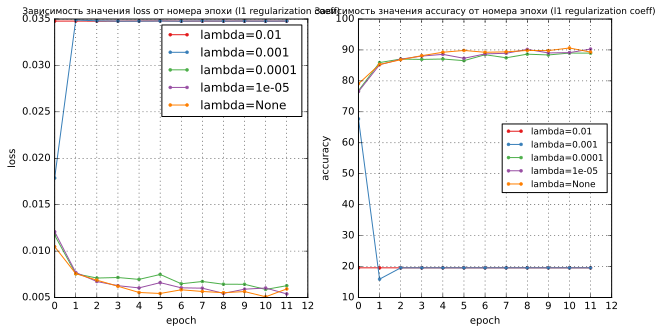

In [160]:
#!g1.1
sns.set_palette("Set1")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Зависимость значения loss от номера эпохи (l1 regularization coeff)", fontsize=9)
for i in range(len(l1_list)):
    plt.plot(np.arange(12), test_l1_info[i]['test_loss'], marker='.', label=f"lambda={l1_list[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend()

ax = fig.add_subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Зависимость значения accuracy от номера эпохи (l1 regularization coeff)", fontsize=9)
for i in range(len(l1_list)):
    plt.plot(np.arange(12), test_l1_info[i]['test_accuracy'], marker='.', label=f"lambda={l1_list[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend(fontsize=9, loc='center right')
plt.show()

## Вывод:

Большие значения коэффициента L1 регуляризации не дают модели обучаться, значения функции потерь не уменьшаются. При маленьких значениях - 0.0001, 0.00001 модель ведет себя так же, как и без нее, поэтому не будем добавлять L1 регуляризацию весов.

# Итоговое сравнение


In [178]:
#!g1.1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                     download=True, transform=transform)


testset = torchvision.datasets.SVHN(root='./data', split='test',
                                    download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64,
                         shuffle=True, num_workers=2)

testloader = DataLoader(testset, batch_size=64,
                        shuffle=False, num_workers=2)

res = []

model = MobileNetV1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Base model:")
test_base_data = optimize_net(
    12, model, optimizer, criterion,
    trainloader, testloader,
    use_cuda=True, verbose=True, l1=None, gc=False
)
res.append(test_base_data)

transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                     download=True, transform=transform_train)


testset = torchvision.datasets.SVHN(root='./data', split='test',
                                    download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=32,
                         shuffle=True, num_workers=2)

testloader = DataLoader(testset, batch_size=32,
                        shuffle=False, num_workers=2)

model = MobileNetV1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
lmbda = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Result model:")
test_res_data = optimize_net(
    12, model, optimizer, criterion,
    trainloader, testloader,
    use_cuda=True, verbose=True, l1=None, gc=True
)
res.append(test_res_data)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


  0%|          | 0/12 [00:00<?, ?it/s]

Base model:


  8%|▊         | 1/12 [00:24<04:32, 24.77s/it]

  epoch: 0, loss: 0.026, accuracy: 0.433


 17%|█▋        | 2/12 [00:48<04:05, 24.55s/it]

  epoch: 1, loss: 0.015, accuracy: 0.681


 25%|██▌       | 3/12 [01:11<03:36, 24.03s/it]

  epoch: 2, loss: 0.011, accuracy: 0.783


 33%|███▎      | 4/12 [01:34<03:10, 23.77s/it]

  epoch: 3, loss: 0.009, accuracy: 0.815


 42%|████▏     | 5/12 [01:57<02:44, 23.53s/it]

  epoch: 4, loss: 0.009, accuracy: 0.834


 50%|█████     | 6/12 [02:20<02:19, 23.32s/it]

  epoch: 5, loss: 0.008, accuracy: 0.842


 58%|█████▊    | 7/12 [02:44<01:57, 23.49s/it]

  epoch: 6, loss: 0.007, accuracy: 0.855


 67%|██████▋   | 8/12 [03:07<01:33, 23.48s/it]

  epoch: 7, loss: 0.007, accuracy: 0.857


 75%|███████▌  | 9/12 [03:31<01:10, 23.43s/it]

  epoch: 8, loss: 0.007, accuracy: 0.860


 83%|████████▎ | 10/12 [03:56<00:47, 23.87s/it]

  epoch: 9, loss: 0.008, accuracy: 0.858


 92%|█████████▏| 11/12 [04:19<00:23, 23.58s/it]

  epoch: 10, loss: 0.007, accuracy: 0.862


100%|██████████| 12/12 [04:42<00:00, 23.54s/it]

  epoch: 11, loss: 0.007, accuracy: 0.865


Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


  0%|          | 0/12 [00:00<?, ?it/s]

Result model:


  8%|▊         | 1/12 [00:54<10:03, 54.90s/it]

  epoch: 0, loss: 0.017, accuracy: 0.834


 17%|█▋        | 2/12 [01:47<09:02, 54.21s/it]

  epoch: 1, loss: 0.015, accuracy: 0.861


 25%|██▌       | 3/12 [02:38<07:59, 53.32s/it]

  epoch: 2, loss: 0.015, accuracy: 0.859


 33%|███▎      | 4/12 [03:30<07:02, 52.85s/it]

  epoch: 3, loss: 0.013, accuracy: 0.878


 42%|████▏     | 5/12 [04:21<06:05, 52.17s/it]

  epoch: 4, loss: 0.012, accuracy: 0.888


 50%|█████     | 6/12 [05:13<05:12, 52.13s/it]

  epoch: 5, loss: 0.012, accuracy: 0.895


 58%|█████▊    | 7/12 [06:03<04:17, 51.54s/it]

  epoch: 6, loss: 0.013, accuracy: 0.880


 67%|██████▋   | 8/12 [06:54<03:25, 51.32s/it]

  epoch: 7, loss: 0.013, accuracy: 0.873


 75%|███████▌  | 9/12 [07:45<02:33, 51.20s/it]

  epoch: 8, loss: 0.012, accuracy: 0.891


 83%|████████▎ | 10/12 [08:37<01:42, 51.49s/it]

  epoch: 9, loss: 0.011, accuracy: 0.897


 92%|█████████▏| 11/12 [09:27<00:51, 51.09s/it]

  epoch: 10, loss: 0.011, accuracy: 0.896


100%|██████████| 12/12 [10:19<00:00, 51.63s/it]

  epoch: 11, loss: 0.011, accuracy: 0.899


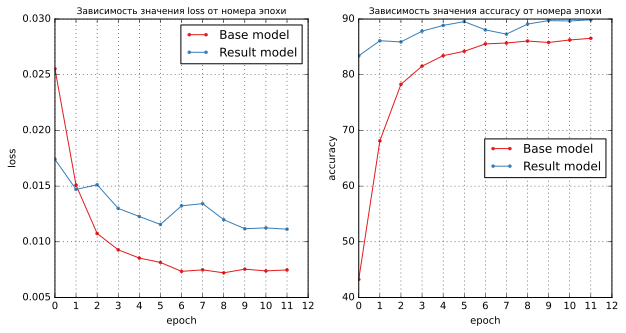

In [180]:
#!g1.1
sns.set_palette("Set1")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Зависимость значения loss от номера эпохи", fontsize=9)

plt.plot(np.arange(12), res[0]['test_loss'], marker='.', label=f"Base model")
plt.plot(np.arange(12), res[1]['test_loss'], marker='.', label=f"Result model")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend()

ax = fig.add_subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Зависимость значения accuracy от номера эпохи", fontsize=9)
plt.plot(np.arange(12), res[0]['test_accuracy'], marker='.', label=f"Base model")
plt.plot(np.arange(12), res[1]['test_accuracy'], marker='.', label=f"Result model")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend(loc='center right')
plt.show()

# Вывод:

После перебора различных параметров удалось улучшить качество классификции модели на 3% и почти досттичь максимального качества этой мобильной нейросети на данном датасете. 